In [1]:
#-----------------------------------------------------------------------------------------------
# Construction cost predictive modeling
# by D. Chakraborty on 8/19/2020
#-----------------------------------------------------------------------------------------------
import random
import pandas as pd
import time
import datetime
import os
import numpy as np
from calendar import isleap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from ngboost.api import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import MLE
from ngboost.evaluation import *
from scipy import stats
from scipy.stats import norm, skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from time import time
from pprint import pprint
import shap
shap.initjs()
import os

In [2]:
def read_tabular_data(file_name,base_dir):
    df      = os.path.join(base_dir,file_name)
    df_read = pd.read_excel(df, thousands=r',')                                   
    return df_read

In [3]:
base_dir = r"C:\Users\wlv446\Documents\AI_Construction_Estimation_Journal_Publication\Data_Files"
###################################################################################################
filename = r"Mixed_Dataset.xlsx"
Data_DF = read_tabular_data(filename, base_dir)

Data_DF= Data_DF[Data_DF['Total Cost ($)'] != 0]
Data_DF.dropna(inplace=True)
Data_DF.to_excel("Mixed_Dataset_No_Zero.xlsx")
Data_DF.rename(columns = {'Area (s.f.)'   : 'Area [$ft^2$]',
                         'Total Load (lbs/s.f.)'   : 'Load [$lbs$/$ft^2$]',
                         'Formwork ($/s.f.)'   : 'Formwork [\$/$ft^2$]',
                         'Elevated Slabs ($/s.f.)'   : 'Slabs [\$/$ft^3$]',
                         'Concrete ($/s.f.)'   : 'Concrete [\$/$ft^3$]',
                         'Total Cost ($)'   : 'Cost [$]'}, inplace = True)
Data_DF.head()

Type  Dim. 1 (ft.)  Dim. 2 (ft.)  Area [$ft^2$]  Load [$lbs$/$ft^2$]  \
0     1            15            15            225                  120   
1     1            15            15            225                  138   
2     1            15            15            225                  188   
3     1            15            15            225                  266   
4     1            15            20            300                  102   

   Formwork [\$/$ft^2$]  Slabs [\$/$ft^3$]  Concrete [\$/$ft^3$]  Cost [$]  
0             22.650336           1.509825              2.105263      9.87  
1             22.650336           1.509825              2.105263      9.96  
2             22.650336           1.509825              2.105263     10.07  
3             22.650336           1.509825              2.105263     10.49  
4             22.650336           1.509825              2.105263      9.82

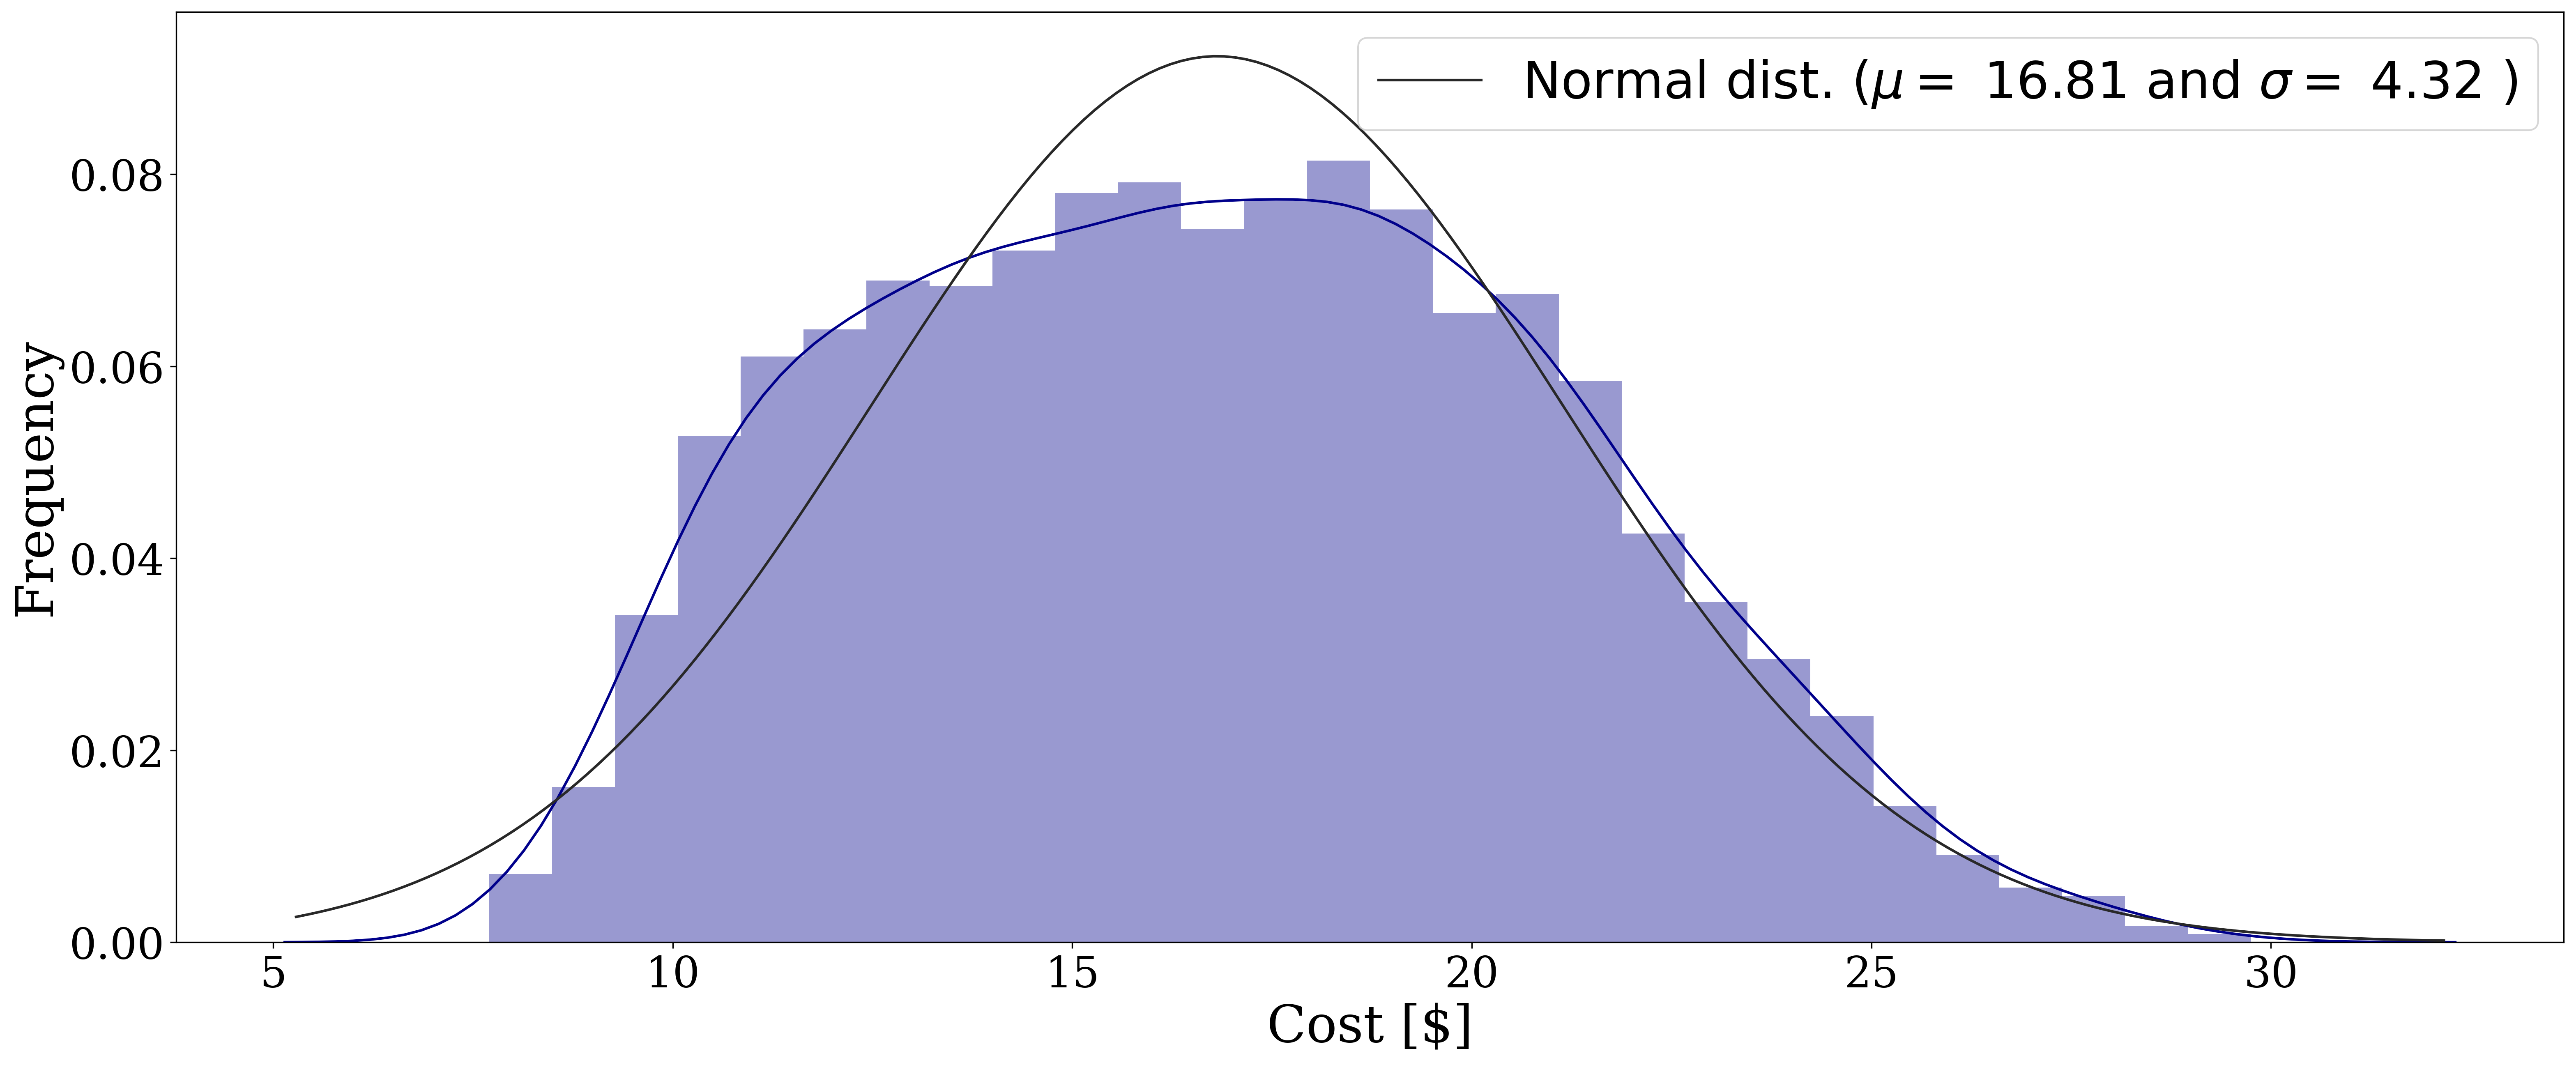

In [4]:
fig = plt.figure(figsize=(25,10),dpi=300)
sns.distplot(Data_DF['Cost [$]'], fit = norm, color='darkblue')
(mu, sigma) = norm.fit(Data_DF['Cost [$]'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.xlabel('Cost [$]', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Assembly Cost Distribution.pdf')

plt.savefig('Assembly Cost Distribution.pdf')

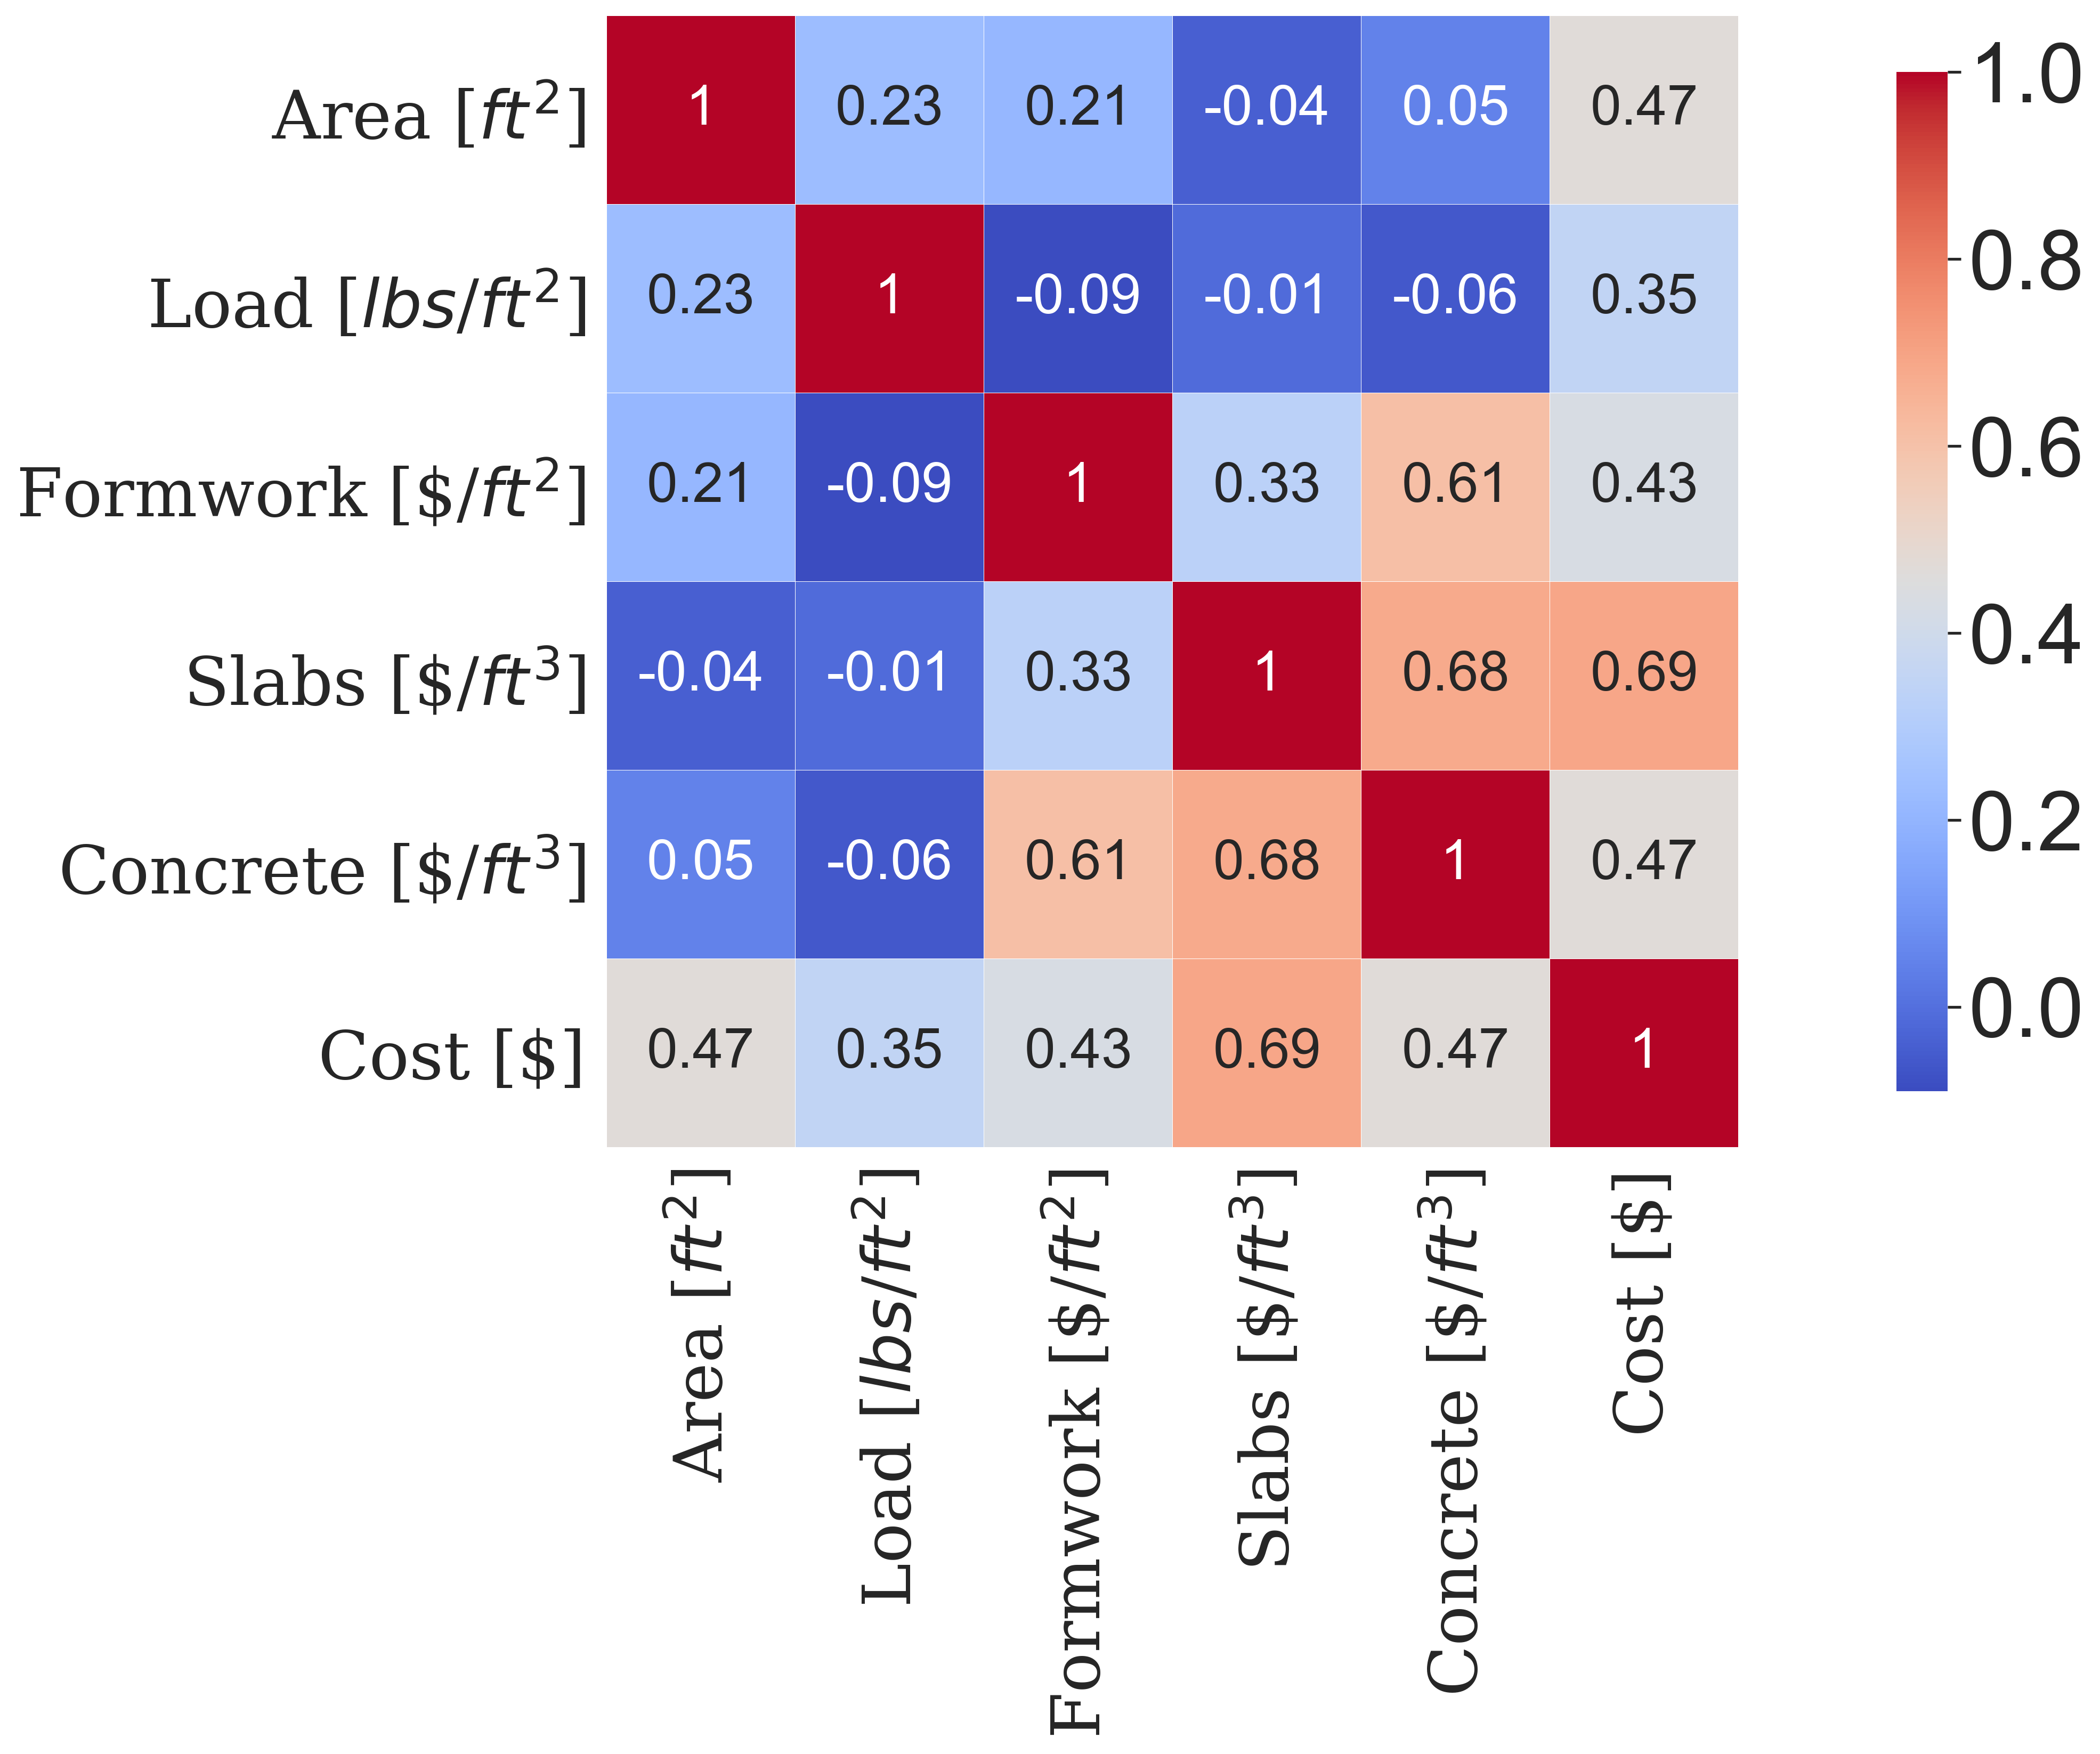

In [5]:
single_variate_corr_1 = Data_DF[['Area [$ft^2$]','Load [$lbs$/$ft^2$]','Formwork [\$/$ft^2$]','Slabs [\$/$ft^3$]',
                                 'Concrete [\$/$ft^3$]','Cost [$]']].corr('pearson')
fig = plt.figure(figsize=(21,12),dpi=300)
sns.set(font_scale=3.4)
sns.heatmap(np.round(single_variate_corr_1,2), vmax=1, square=True, linewidths=.1, annot=True, annot_kws={"size": 25}, 
            cbar_kws={"shrink": .9}, cmap='coolwarm')
plt.xticks(fontsize=30, fontname='Serif', rotation=90)
plt.yticks(fontsize=30, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.tight_layout(pad=1.08)
fig.savefig('Correlation Heatmap.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

In [6]:
Feature_Names = ['Area [$ft^2$]','Load [$lbs$/$ft^2$]','Formwork [\$/$ft^2$]','Slabs [\$/$ft^3$]','Concrete [\$/$ft^3$]']

X = Data_DF[Feature_Names].to_numpy()
y = Data_DF['Cost [$]'].to_numpy()
#################################################################################################
# To test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=7)
#################################################################################################
np.random.seed(7)
scoring_param = make_scorer(mean_squared_error,greater_is_better=False)
#################################################################################################

# Linear Regression

In [7]:
t0 = time()

lin_reg = LinearRegression(normalize=True).fit(X_train, y_train)

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")

Y_Train_Pred = lin_reg.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_Test_Pred = lin_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")
################################################################
################################################################
print("############ Model Coefficients ############")
print(np.round((lin_reg.coef_),2))

Time taken to train the model: 0.04 seconds
############ Model Accuracy on Daily Training Data ############
RMSE: 1.799
R-squared: 0.827
MBE: 0.000
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 1.774
R-squared: 0.831
MBE: -0.022
########################################
 
############ Model Coefficients ############
[ 0.    0.02  0.11  8.81 -0.92]


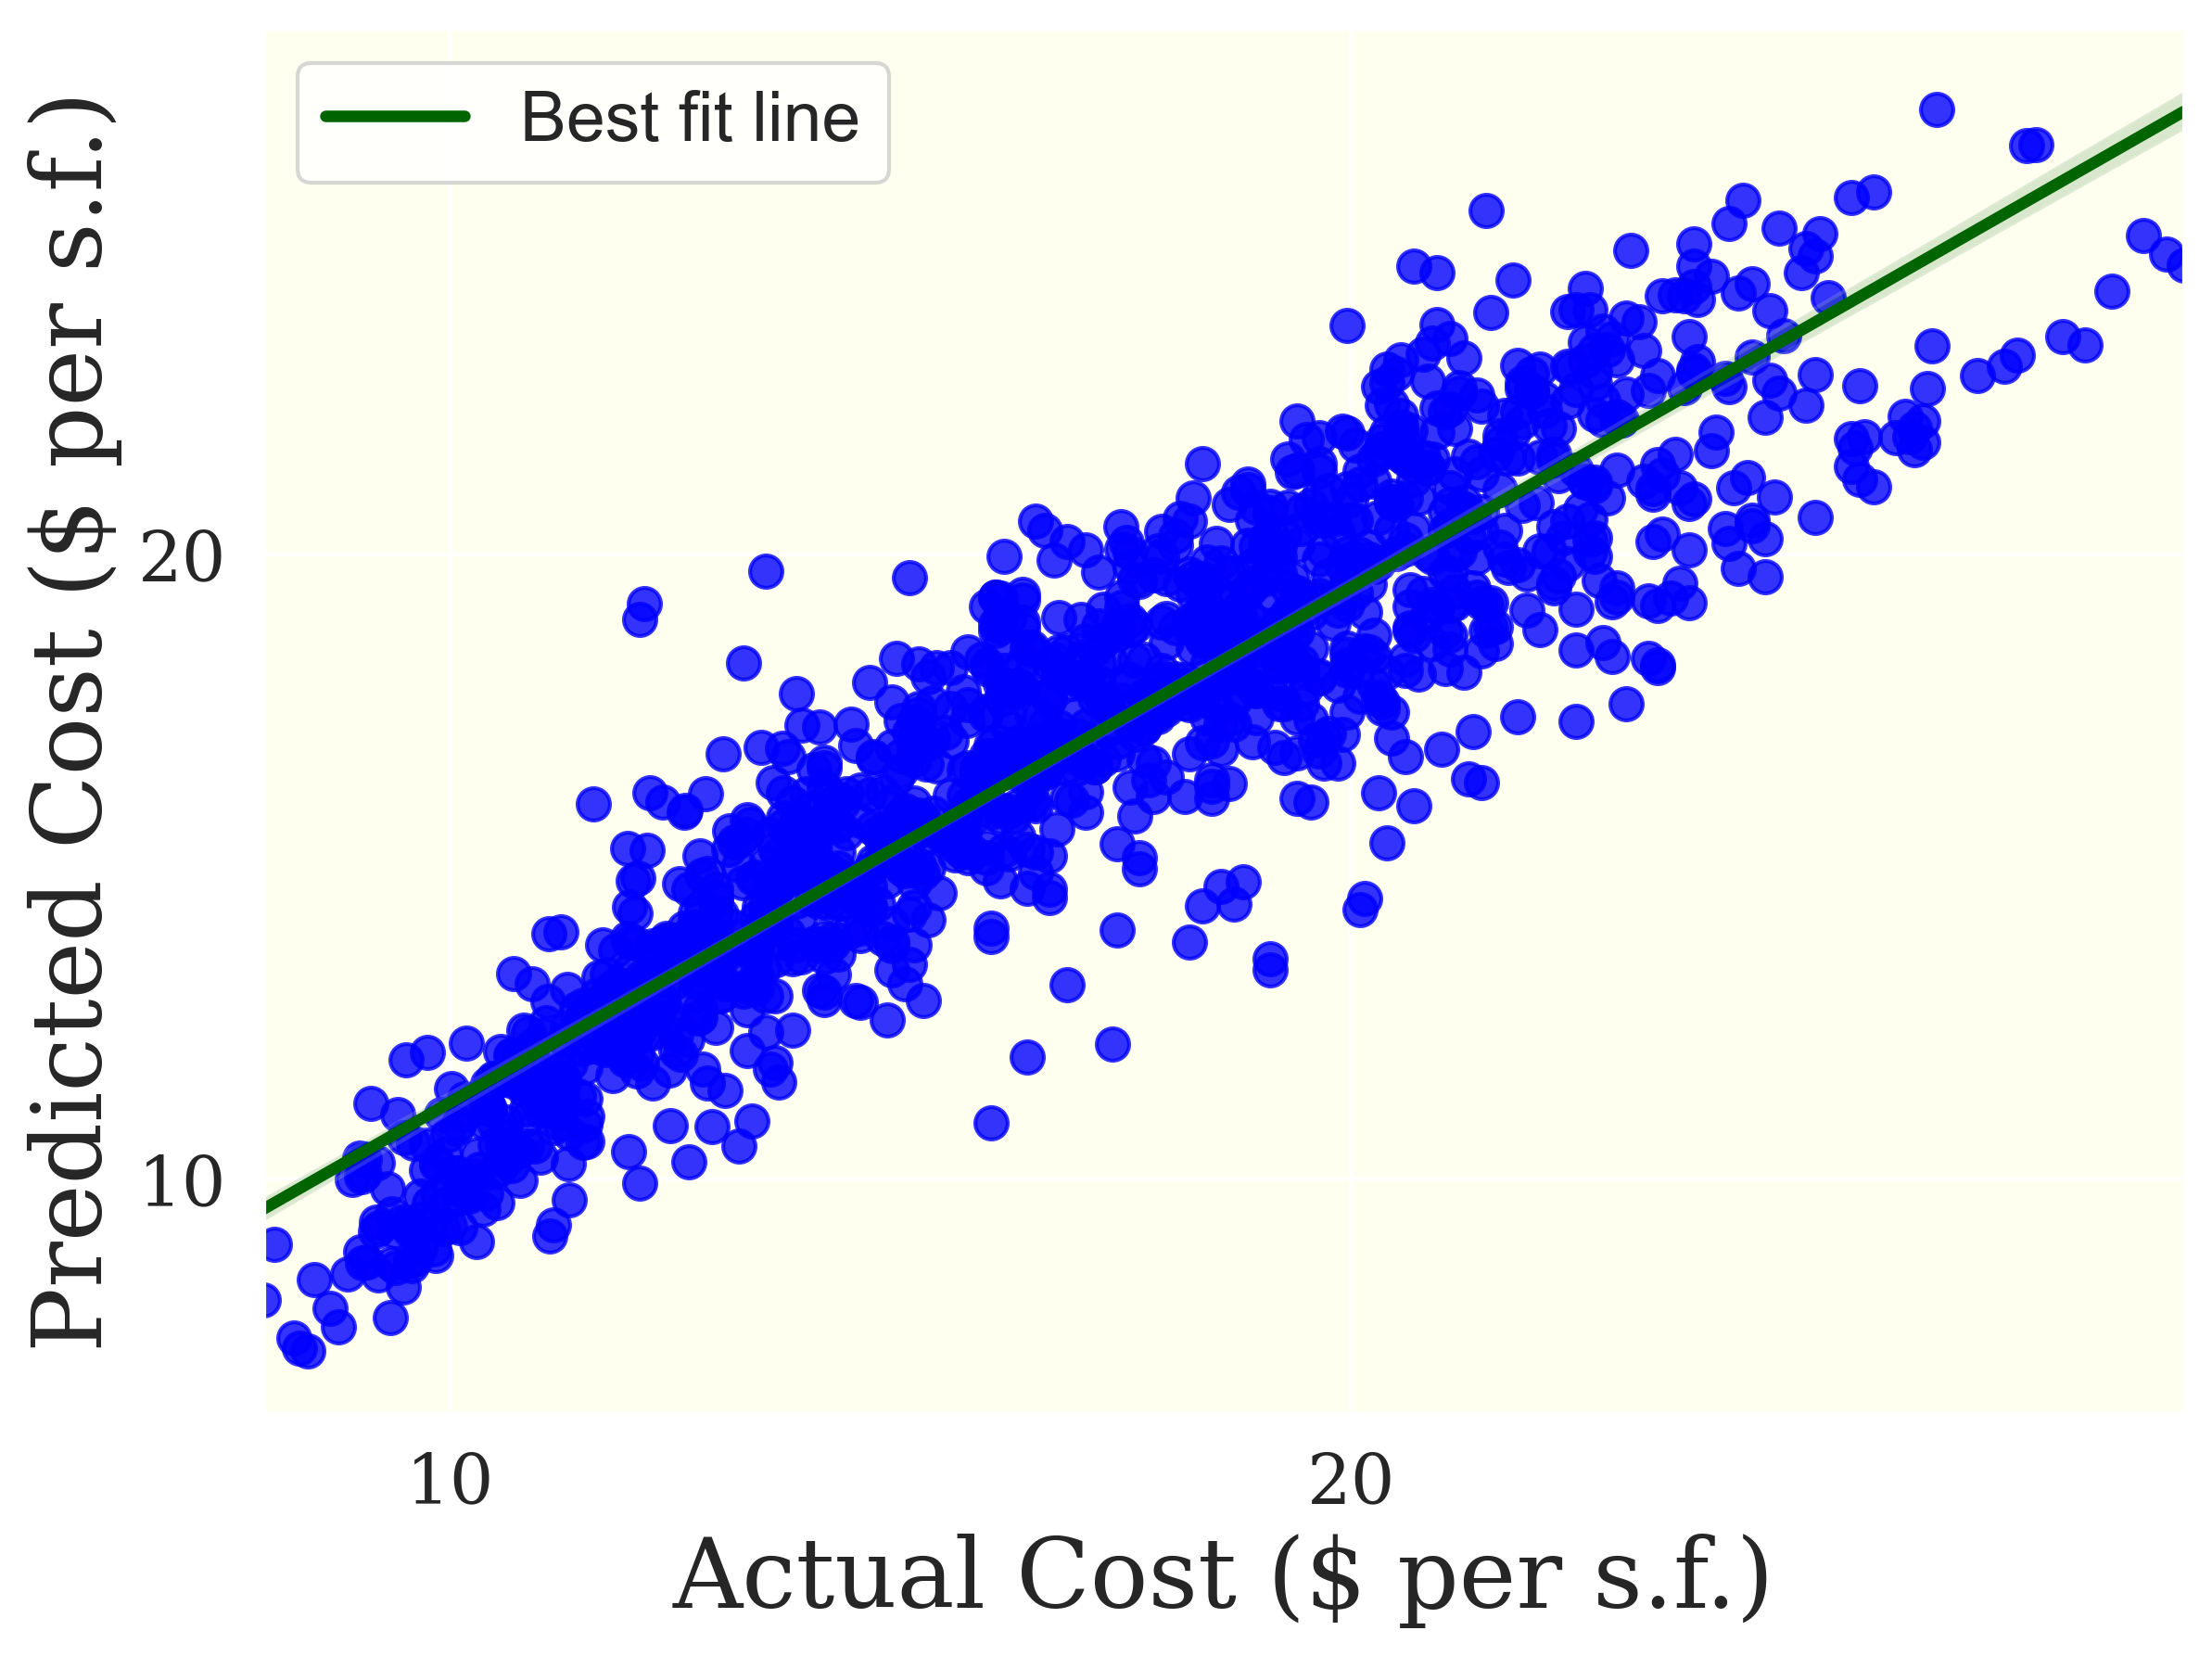

In [8]:
fig = plt.figure(figsize=(9,7),dpi=300)
ax = fig.add_subplot(1,1,1,facecolor='ivory')
sns.regplot(y_test, Y_Test_Pred, scatter_kws={'color': 'blue', 's': 70},
            line_kws={'color': 'darkgreen', 'linewidth': 3, 'label': 'Best fit line'})


plt.xlabel("Actual Cost ($ per s.f.)", fontsize=25, fontname='Serif')
plt.ylabel("Predicted Cost ($ per s.f.)", fontsize=25, fontname='Serif')
plt.xticks(fontsize=18, fontname='Serif')
plt.yticks(fontsize=18, fontname='Serif')
plt.figaspect(1.)
plt.legend(loc='upper left', prop={'size': 18}, facecolor='white')
plt.tight_layout(pad=1.1)
plt.savefig('Scatter Plot - LR.pdf',dpi=300,format='pdf')

# Random Forest

In [9]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
    max_depth = [int(i) for i in np.linspace(1,10,num=10)],
  min_samples_leaf = [int(i) for i in np.linspace(1,10,num=10)])

rf = GridSearchCV(estimator = RandomForestRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

rf.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best RF Estimators: %0.3f" % rf.best_params_.get('n_estimators'))
print("Best RF Max Depth: %0.3f" % rf.best_params_.get('max_depth'))
print("Best RF Min Samples in Leaf: %0.3f" % rf.best_params_.get('min_samples_leaf'))

Y_Train_Pred = rf.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_Test_Pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2378 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3978 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  9.6min finished


Time taken to train the model: 584.27 seconds
Best RF Estimators: 2000.000
Best RF Max Depth: 10.000
Best RF Min Samples in Leaf: 1.000
############ Model Accuracy on Daily Training Data ############
RMSE: 0.399
R-squared: 0.992
MBE: 0.003
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 0.729
R-squared: 0.971
MBE: -0.034
########################################
 


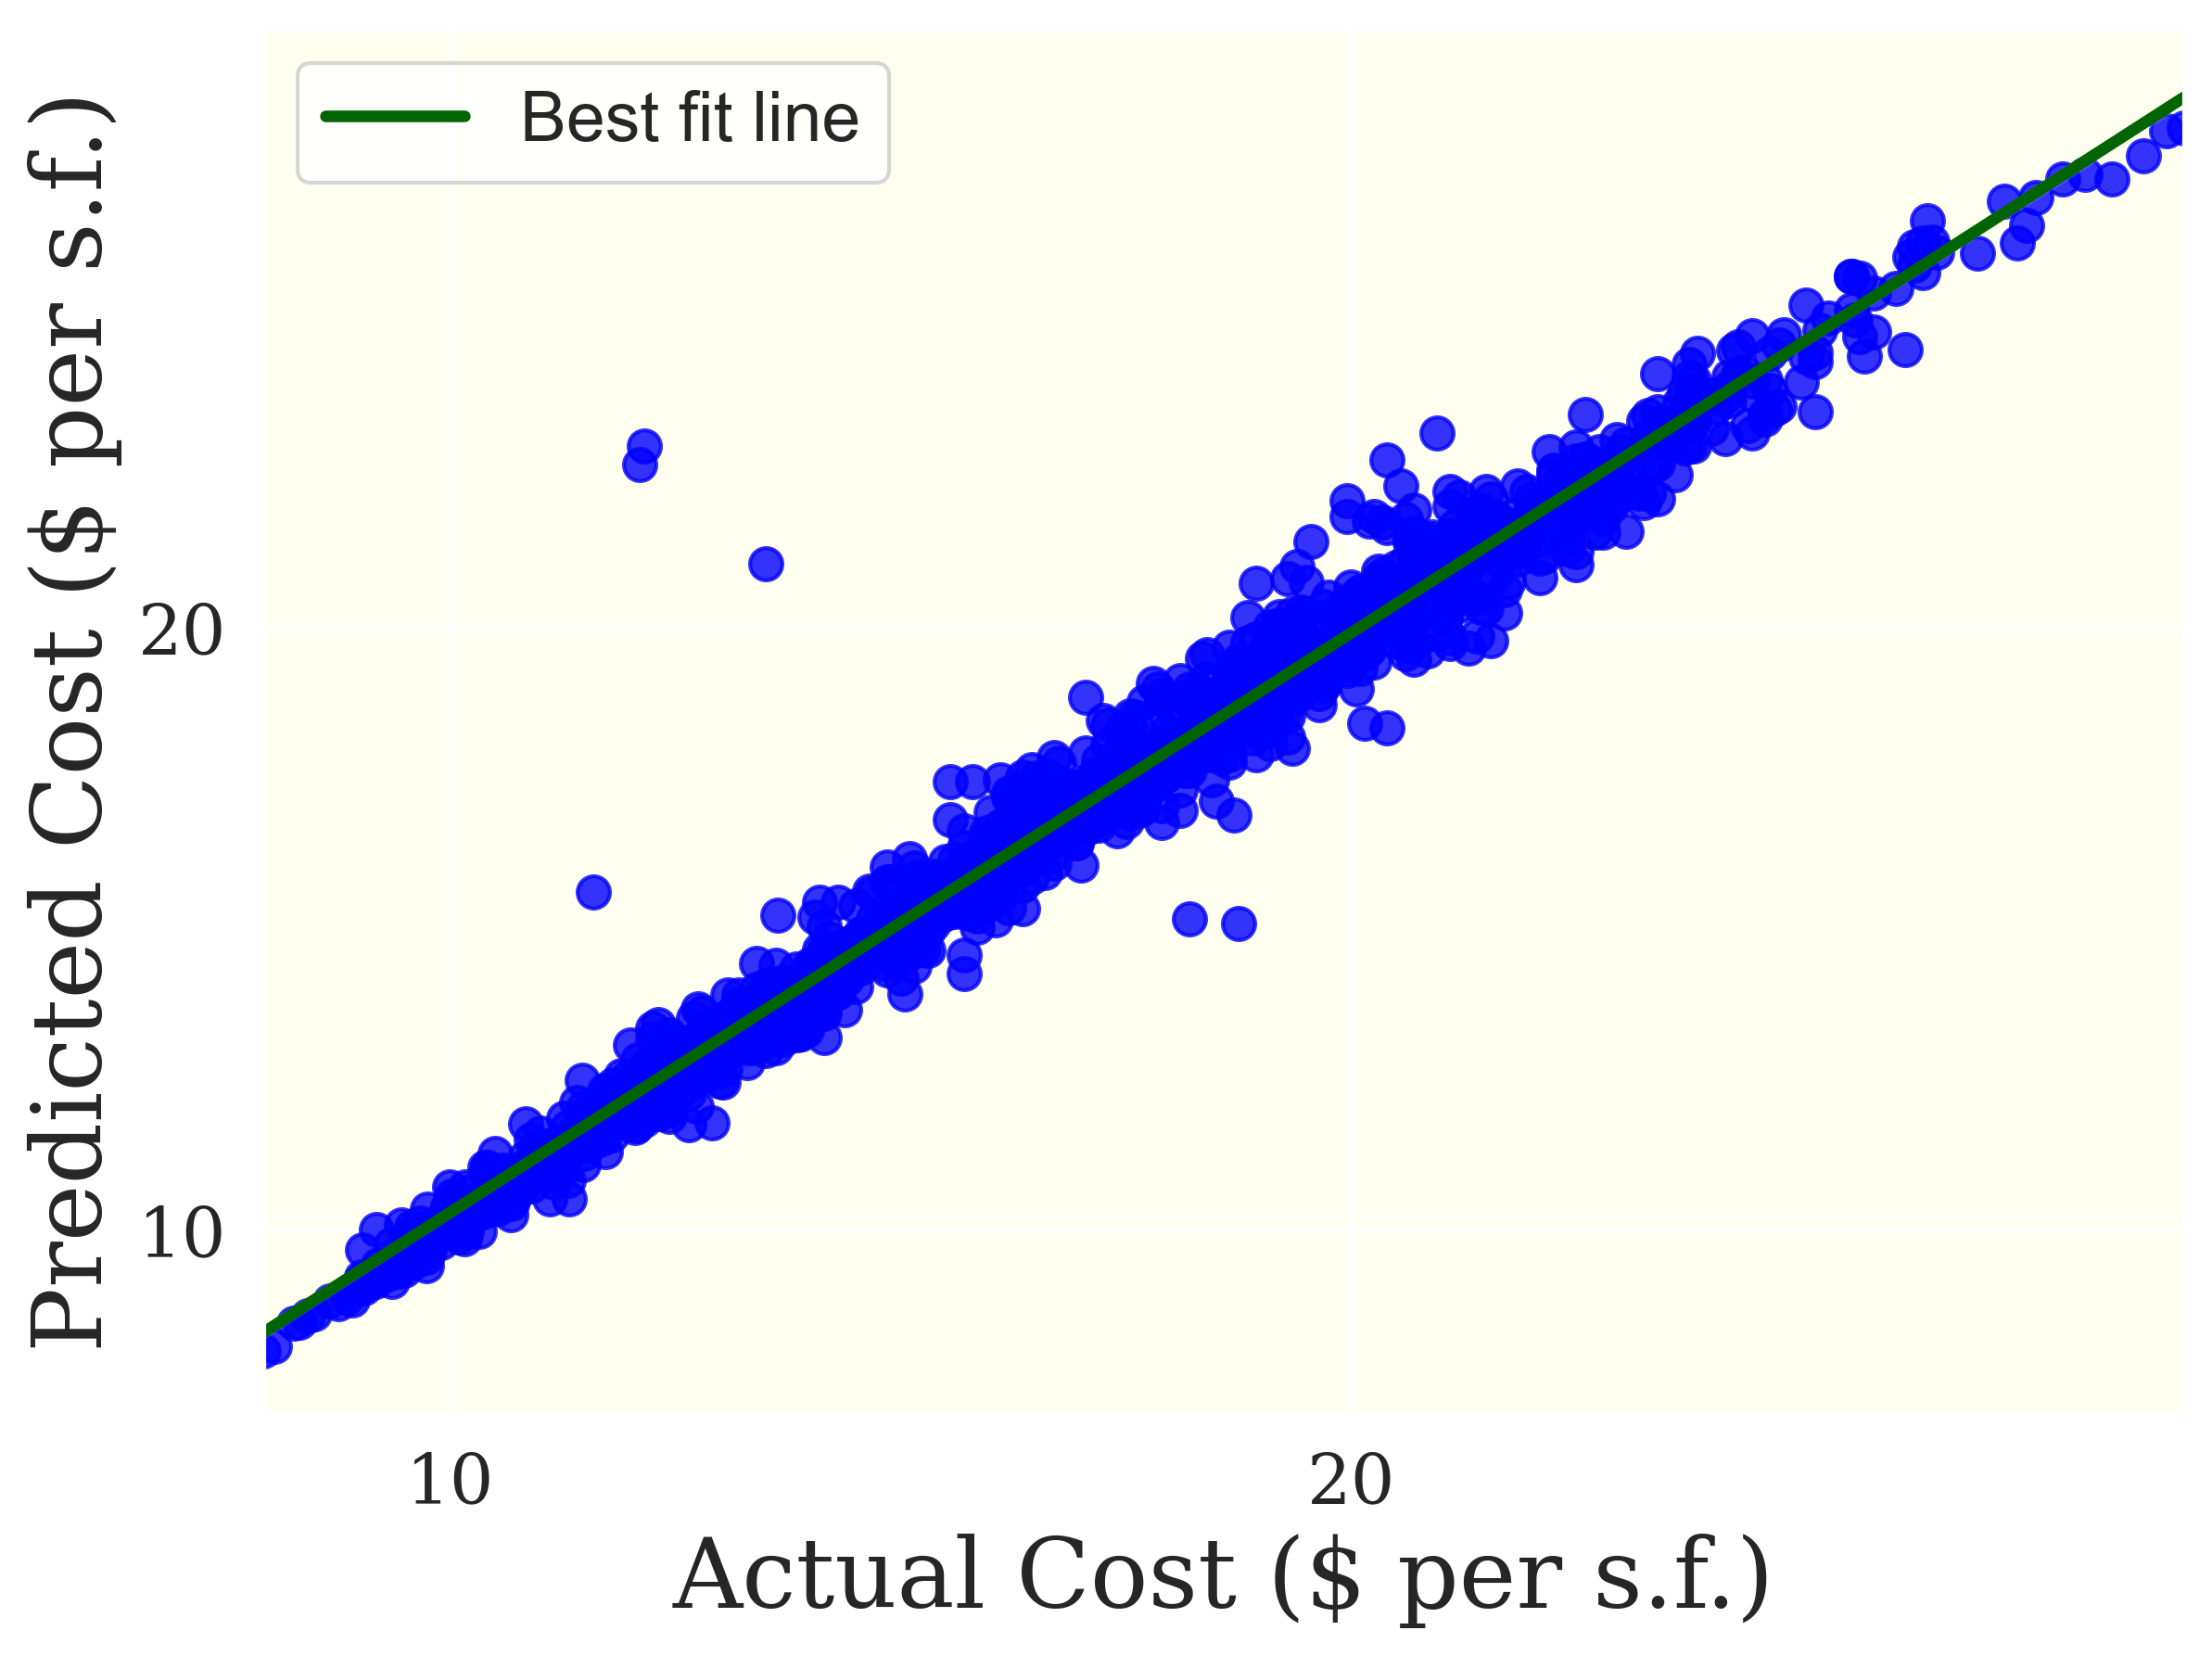

In [10]:
fig = plt.figure(figsize=(9,7),dpi=300)
ax = fig.add_subplot(1,1,1,facecolor='ivory')
sns.regplot(y_test, Y_Test_Pred, scatter_kws={'color': 'blue', 's': 70},
            line_kws={'color': 'darkgreen', 'linewidth': 3, 'label': 'Best fit line'})


plt.xlabel("Actual Cost ($ per s.f.)", fontsize=25, fontname='Serif')
plt.ylabel("Predicted Cost ($ per s.f.)", fontsize=25, fontname='Serif')
plt.xticks(fontsize=18, fontname='Serif')
plt.yticks(fontsize=18, fontname='Serif')
plt.figaspect(1.)
plt.legend(loc='upper left', prop={'size': 18}, facecolor='white')
plt.tight_layout(pad=1.1)
plt.savefig('Scatter Plot - RF.pdf',dpi=300,format='pdf')

# XGBoost

In [11]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
    max_depth = [int(i) for i in np.linspace(1,10,num=10)],
  learning_rate = np.linspace(0.001,0.1,num=10))

xgb = GridSearchCV(estimator = XGBRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

xgb.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best XGB Estimators: %0.3f" % xgb.best_params_.get('n_estimators'))
print("Best XGB Max Depth: %0.3f" % xgb.best_params_.get('max_depth'))
print("Best XGB Learning Rate: %0.3f" % xgb.best_params_.get('learning_rate'))

Y_Train_Pred = xgb.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_Test_Pred = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2378 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3978 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  4.8min finished


Time taken to train the model: 290.67 seconds
Best XGB Estimators: 2000.000
Best XGB Max Depth: 3.000
Best XGB Learning Rate: 0.100
############ Model Accuracy on Daily Training Data ############
RMSE: 0.165
R-squared: 0.999
MBE: 0.000
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 0.534
R-squared: 0.985
MBE: -0.020
########################################
 


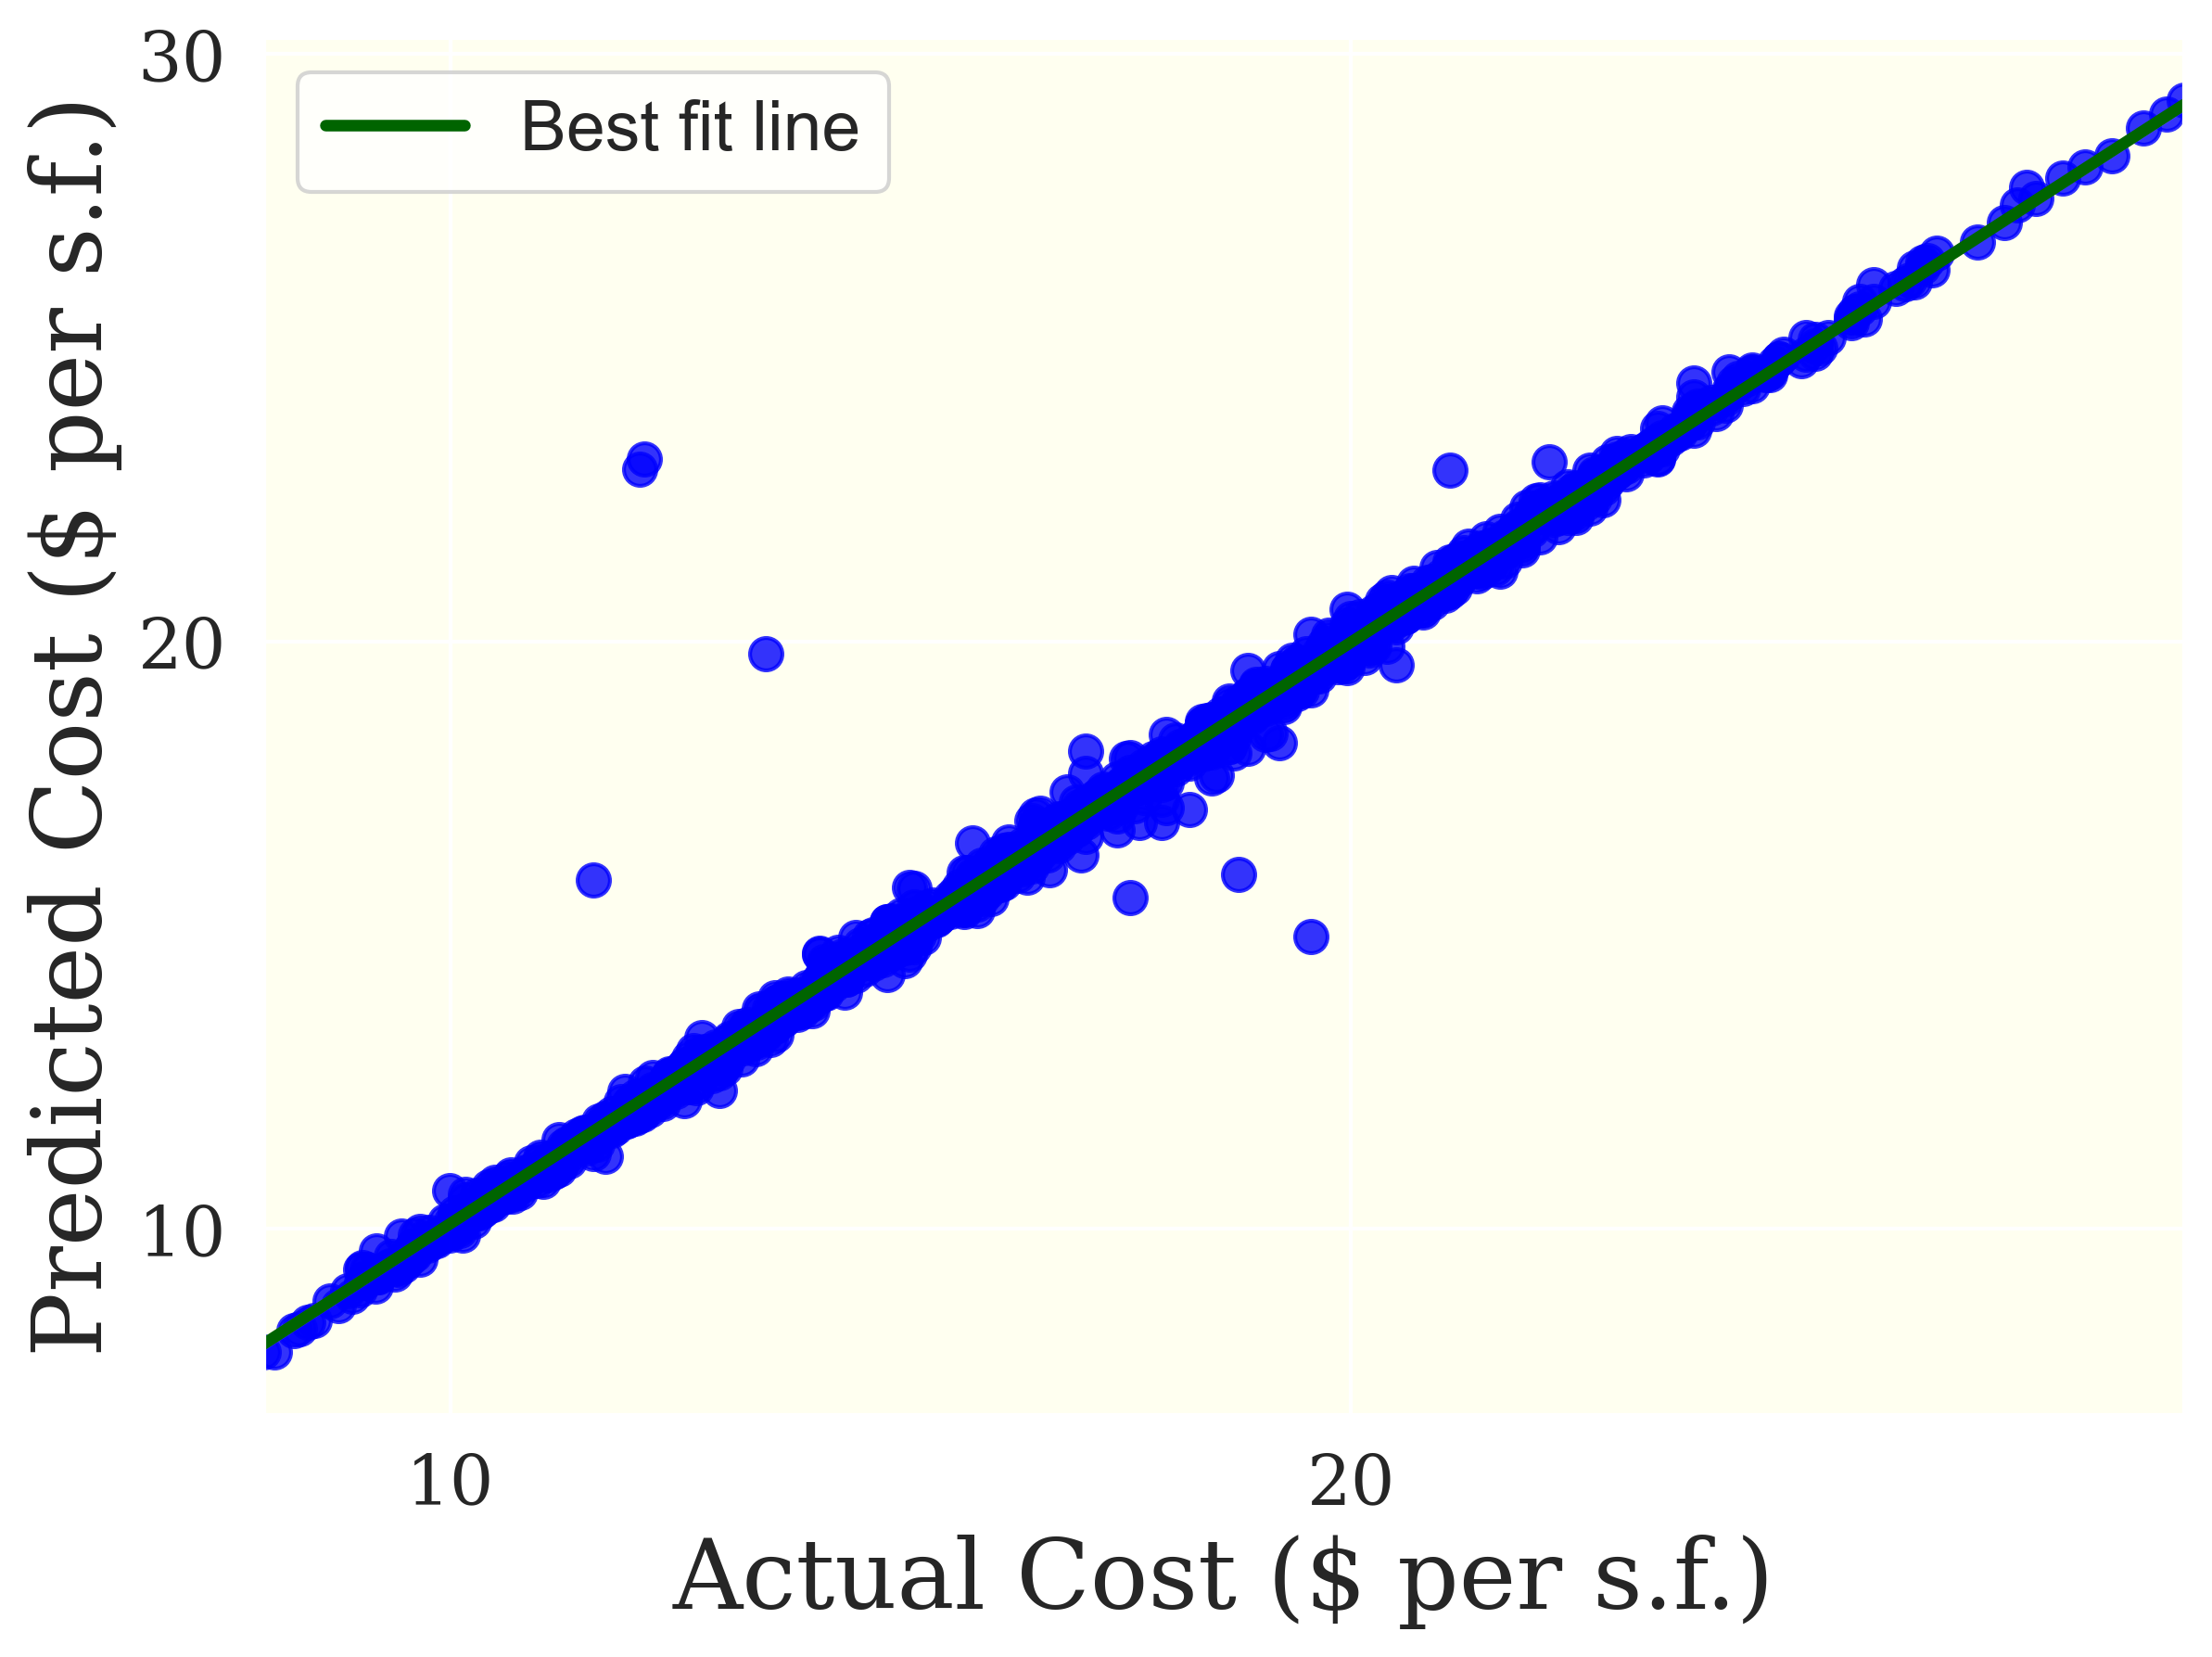

In [12]:
fig = plt.figure(figsize=(9,7),dpi=300)
ax = fig.add_subplot(1,1,1,facecolor='ivory')
sns.regplot(y_test, Y_Test_Pred, scatter_kws={'color': 'blue', 's': 70},
            line_kws={'color': 'darkgreen', 'linewidth': 3, 'label': 'Best fit line'})


plt.xlabel("Actual Cost ($ per s.f.)", fontsize=25, fontname='Serif')
plt.ylabel("Predicted Cost ($ per s.f.)", fontsize=25, fontname='Serif')
plt.xticks(fontsize=18, fontname='Serif')
plt.yticks(fontsize=18, fontname='Serif')
plt.figaspect(1.)
plt.legend(loc='upper left', prop={'size': 18}, facecolor='white')
plt.tight_layout(pad=1.1)
plt.savefig('Scatter Plot - XGB.pdf',dpi=300,format='pdf')

# Light GBM

In [13]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
    max_depth = [int(i) for i in np.linspace(1,10,num=10)],
  learning_rate = np.linspace(0.001,0.1,num=10))

lgb = GridSearchCV(estimator = LGBMRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

lgb.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best LGB Estimators: %0.3f" % lgb.best_params_.get('n_estimators'))
print("Best LGB Max Depth: %0.3f" % lgb.best_params_.get('max_depth'))
print("Best LGB Learning Rate: %0.3f" % lgb.best_params_.get('learning_rate'))

Y_Train_Pred = lgb.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_Test_Pred = lgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 558 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 908 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 1358 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 1908 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 2558 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 3308 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5108 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  2.3min finished


Time taken to train the model: 137.89 seconds
Best LGB Estimators: 2000.000
Best LGB Max Depth: 3.000
Best LGB Learning Rate: 0.089
############ Model Accuracy on Daily Training Data ############
RMSE: 0.225
R-squared: 0.997
MBE: 0.000
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 0.536
R-squared: 0.985
MBE: -0.025
########################################
 


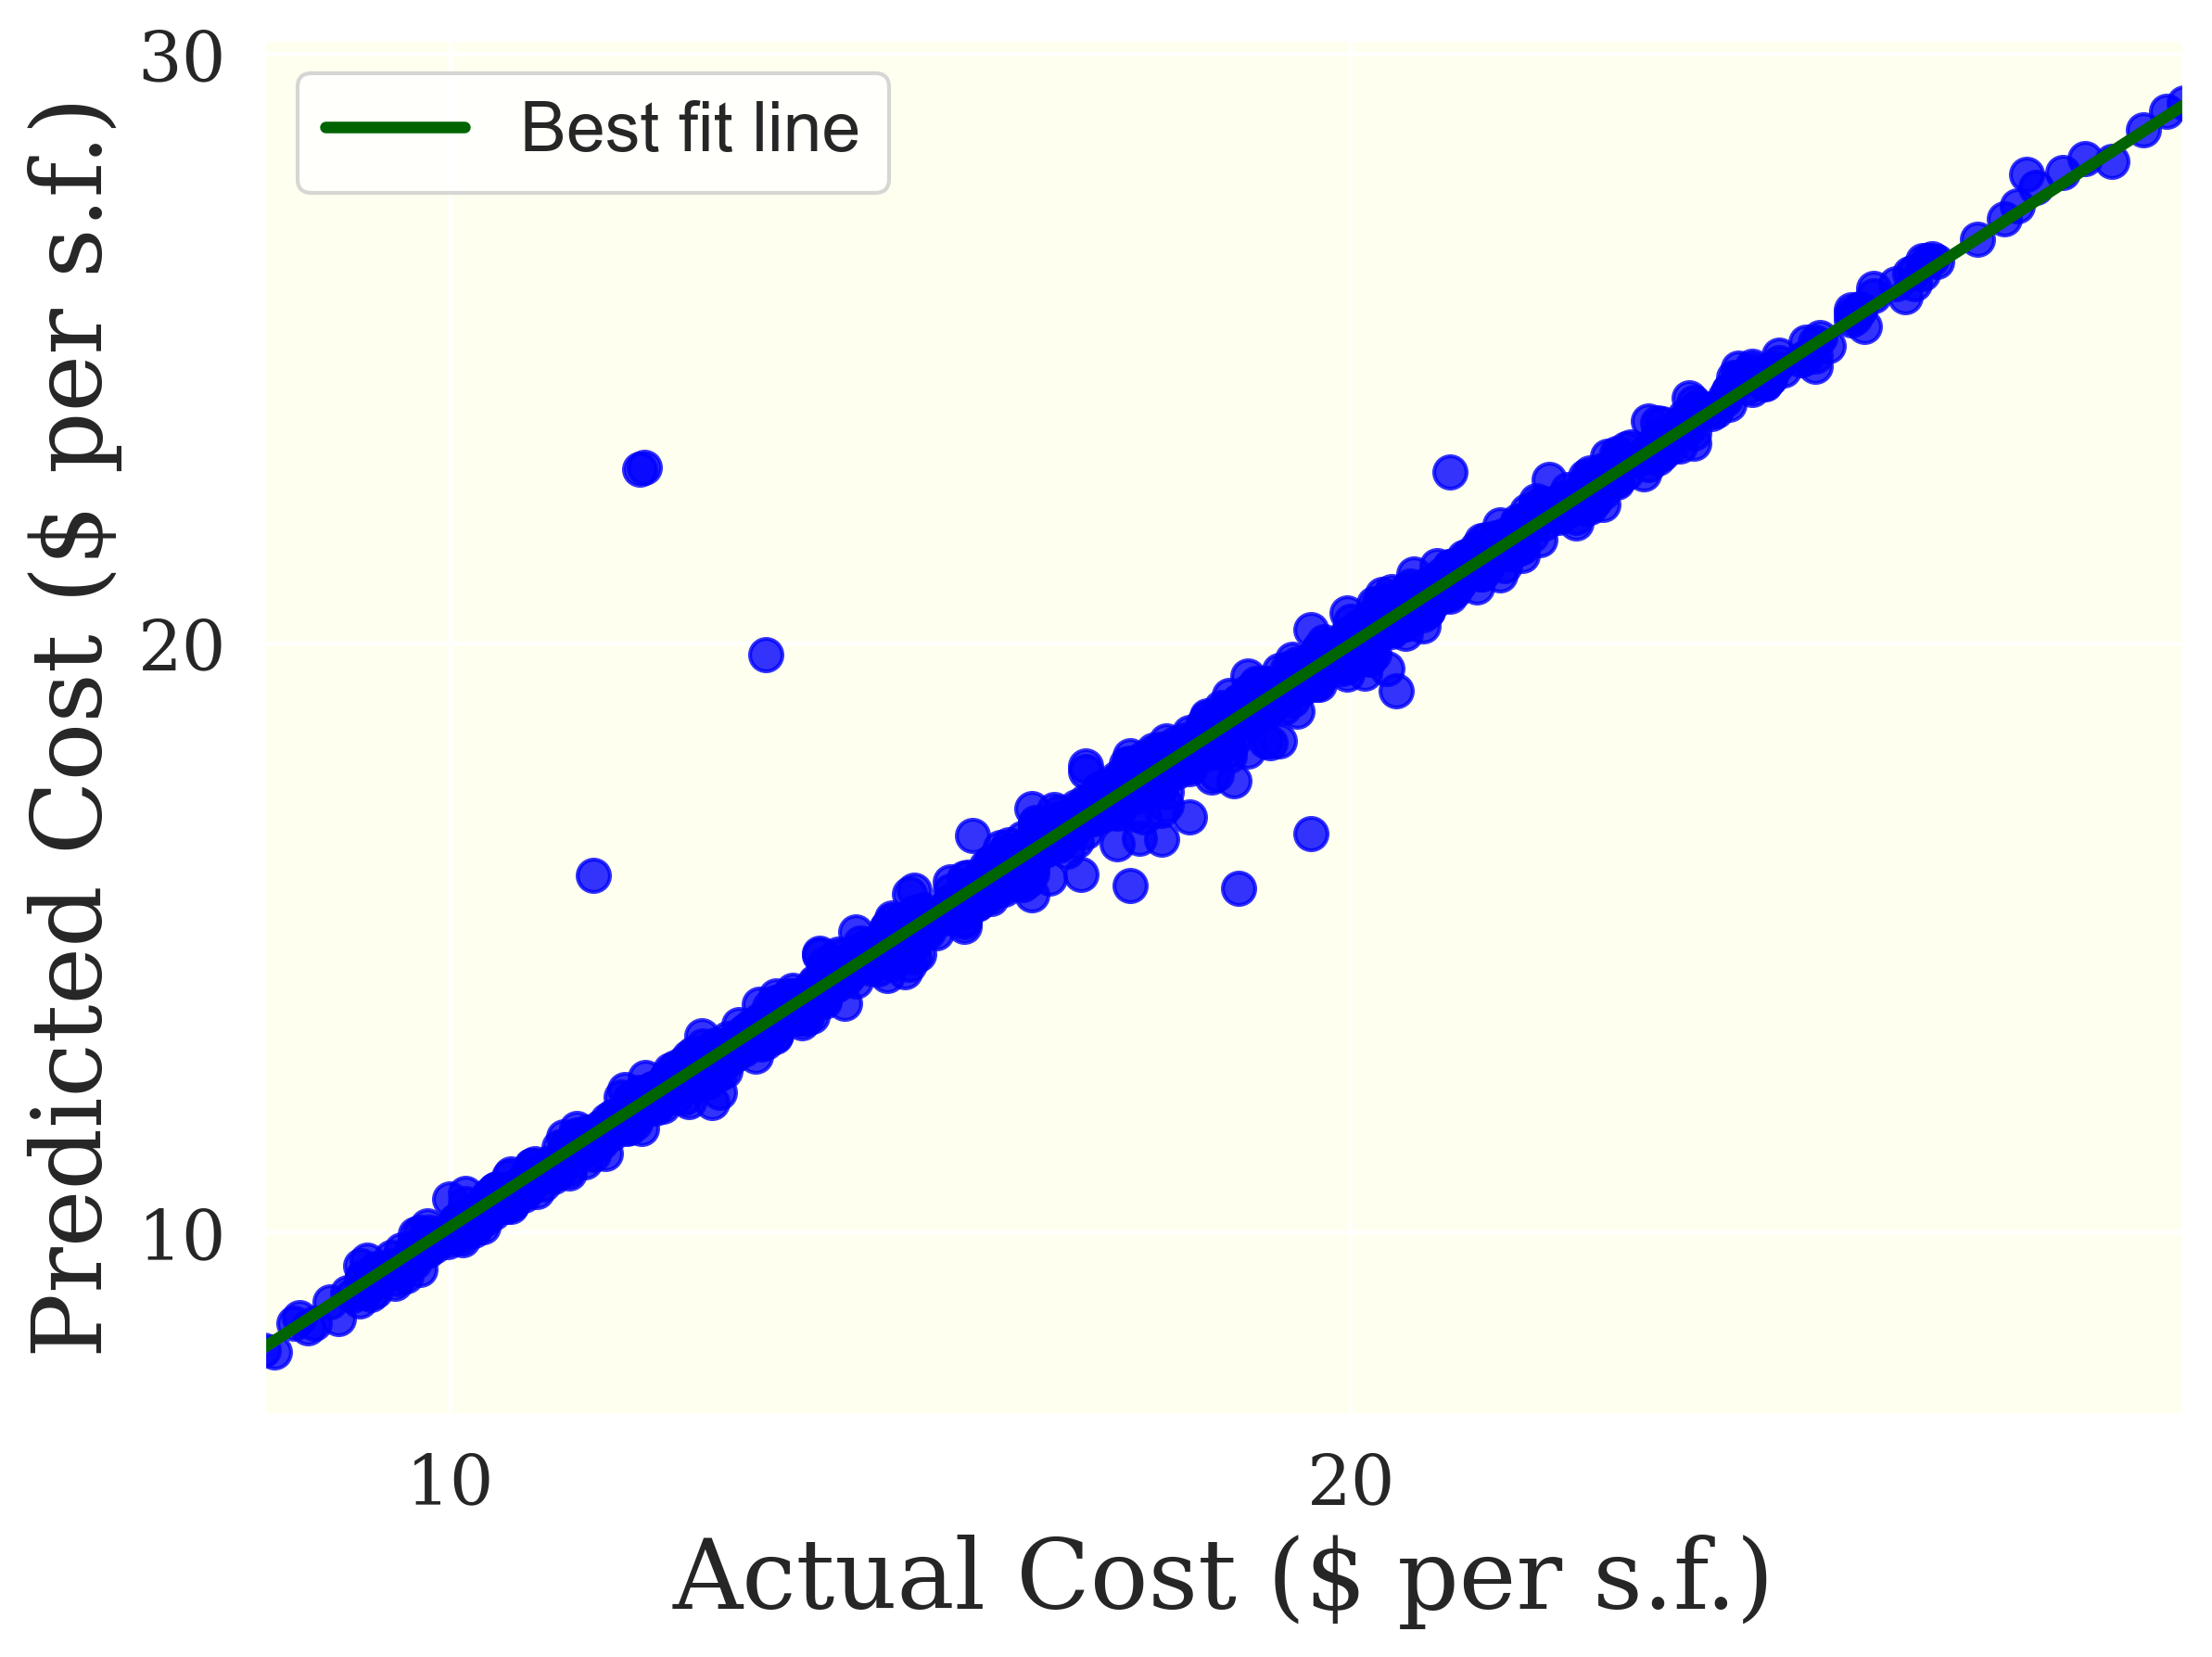

In [14]:
fig = plt.figure(figsize=(9,7),dpi=300)
ax = fig.add_subplot(1,1,1,facecolor='ivory')
sns.regplot(y_test, Y_Test_Pred, scatter_kws={'color': 'blue', 's': 70},
            line_kws={'color': 'darkgreen', 'linewidth': 3, 'label': 'Best fit line'})


plt.xlabel("Actual Cost ($ per s.f.)", fontsize=25, fontname='Serif')
plt.ylabel("Predicted Cost ($ per s.f.)", fontsize=25, fontname='Serif')
plt.xticks(fontsize=18, fontname='Serif')
plt.yticks(fontsize=18, fontname='Serif')
plt.figaspect(1.)
plt.legend(loc='upper left', prop={'size': 18}, facecolor='white')
plt.tight_layout(pad=1.1)
plt.savefig('Scatter Plot - LGBM.pdf',dpi=300,format='pdf')

# Natural GBM

In [15]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
              minibatch_frac = np.linspace(0.1,1,num=10),
              learning_rate = np.linspace(0.01,0.1,num=10))

ngb = GridSearchCV(estimator = NGBRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

ngb.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best NGB Estimators: %0.3f" % ngb.best_params_.get('n_estimators'))
print("Best NGB Minibatch Fraction: %0.3f" % ngb.best_params_.get('minibatch_frac'))
print("Best NGB Learning Rate: %0.3f" % ngb.best_params_.get('learning_rate'))

ngb = NGBRegressor(n_estimators = ngb.best_params_.get('n_estimators'), minibatch_frac = ngb.best_params_.get('minibatch_frac'),
                   learning_rate = ngb.best_params_.get('learning_rate'), random_state=7)

ngb.fit(X_train, y_train.ravel())

Y_Train_Pred = ngb.pred_dist(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(), Y_Train_Pred.dist.mean()))
RSQ = r2_score(y_train.ravel(), Y_Train_Pred.dist.mean())
MBE = np.mean(y_train.ravel() - Y_Train_Pred.loc)
################################################################
UB = (Y_Train_Pred.loc + 1.96 * Y_Train_Pred.scale)
LB = (Y_Train_Pred.loc - 1.96 * Y_Train_Pred.scale)
count = 0
n = len(y_train)
for i in range(n):
    if (y_train[i] <= UB[i] and y_train[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

Y_Test_Pred = ngb.pred_dist(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred.loc))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred.loc)
MBE = np.mean(y_test.ravel() - Y_Test_Pred.loc)
################################################################
UB = (Y_Test_Pred.loc + 1.96 * Y_Test_Pred.scale)
LB = (Y_Test_Pred.loc - 1.96 * Y_Test_Pred.scale)
count = 0
n = len(y_test)
for i in range(n):
    if (y_test[i] <= UB[i] and y_test[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy on Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 2378 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 3978 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 33.8min finished


[iter 0] loss=2.8970 val_loss=0.0000 scale=1.0000 norm=3.7131
[iter 100] loss=0.6701 val_loss=0.0000 scale=1.0000 norm=0.6514
[iter 200] loss=0.3820 val_loss=0.0000 scale=1.0000 norm=0.5909
[iter 300] loss=0.1683 val_loss=0.0000 scale=1.0000 norm=0.5343
[iter 400] loss=0.0643 val_loss=0.0000 scale=0.5000 norm=0.2607
[iter 500] loss=-0.0574 val_loss=0.0000 scale=1.0000 norm=0.5029
[iter 600] loss=-0.1225 val_loss=0.0000 scale=1.0000 norm=0.4984
[iter 700] loss=-0.1750 val_loss=0.0000 scale=1.0000 norm=0.4882
[iter 800] loss=-0.2272 val_loss=0.0000 scale=1.0000 norm=0.4909
[iter 900] loss=-0.3118 val_loss=0.0000 scale=0.5000 norm=0.2362
[iter 1000] loss=-0.3591 val_loss=0.0000 scale=0.5000 norm=0.2289
[iter 1100] loss=-0.4149 val_loss=0.0000 scale=1.0000 norm=0.4594
[iter 1200] loss=-0.4223 val_loss=0.0000 scale=1.0000 norm=0.4727
[iter 1300] loss=-0.4888 val_loss=0.0000 scale=0.5000 norm=0.2208
[iter 1400] loss=-0.5135 val_loss=0.0000 scale=0.5000 norm=0.2259
[iter 1500] loss=-0.5587 va

In [16]:
t0 = time()

ngb_default = NGBRegressor(random_state=7)

ngb_default.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")

Y_Train_Pred = ngb_default.pred_dist(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(), Y_Train_Pred.dist.mean()))
RSQ = r2_score(y_train.ravel(), Y_Train_Pred.dist.mean())
MBE = np.mean(y_train.ravel() - Y_Train_Pred.loc)
################################################################
UB = (Y_Train_Pred.loc + 1.96 * Y_Train_Pred.scale)
LB = (Y_Train_Pred.loc - 1.96 * Y_Train_Pred.scale)
count = 0
n = len(y_train)
for i in range(n):
    if (y_train[i] <= UB[i] and y_train[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

Y_Test_Pred = ngb_default.pred_dist(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred.loc))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred.loc)
MBE = np.mean(y_test.ravel() - Y_Test_Pred.loc)
################################################################
UB = (Y_Test_Pred.loc + 1.96 * Y_Test_Pred.scale)
LB = (Y_Test_Pred.loc - 1.96 * Y_Test_Pred.scale)
count = 0
n = len(y_test)
for i in range(n):
    if (y_test[i] <= UB[i] and y_test[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy on Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

[iter 0] loss=2.8841 val_loss=0.0000 scale=1.0000 norm=3.6632
[iter 100] loss=2.3588 val_loss=0.0000 scale=2.0000 norm=4.0020
[iter 200] loss=1.7333 val_loss=0.0000 scale=2.0000 norm=2.1927
[iter 300] loss=1.2666 val_loss=0.0000 scale=2.0000 norm=1.6674
[iter 400] loss=1.0071 val_loss=0.0000 scale=1.0000 norm=0.7429
Time taken to train the model: 4.10 seconds
############ Model Accuracy ############
RMSE: 0.671
R-squared: 0.976
MBE: 0.000
# of points inside PI: 98.4 %
########################################
 
############ Model Accuracy on Testing Data ############
RMSE: 0.788
R-squared: 0.967
MBE: -0.038
# of points inside PI: 97.5 %
########################################
 


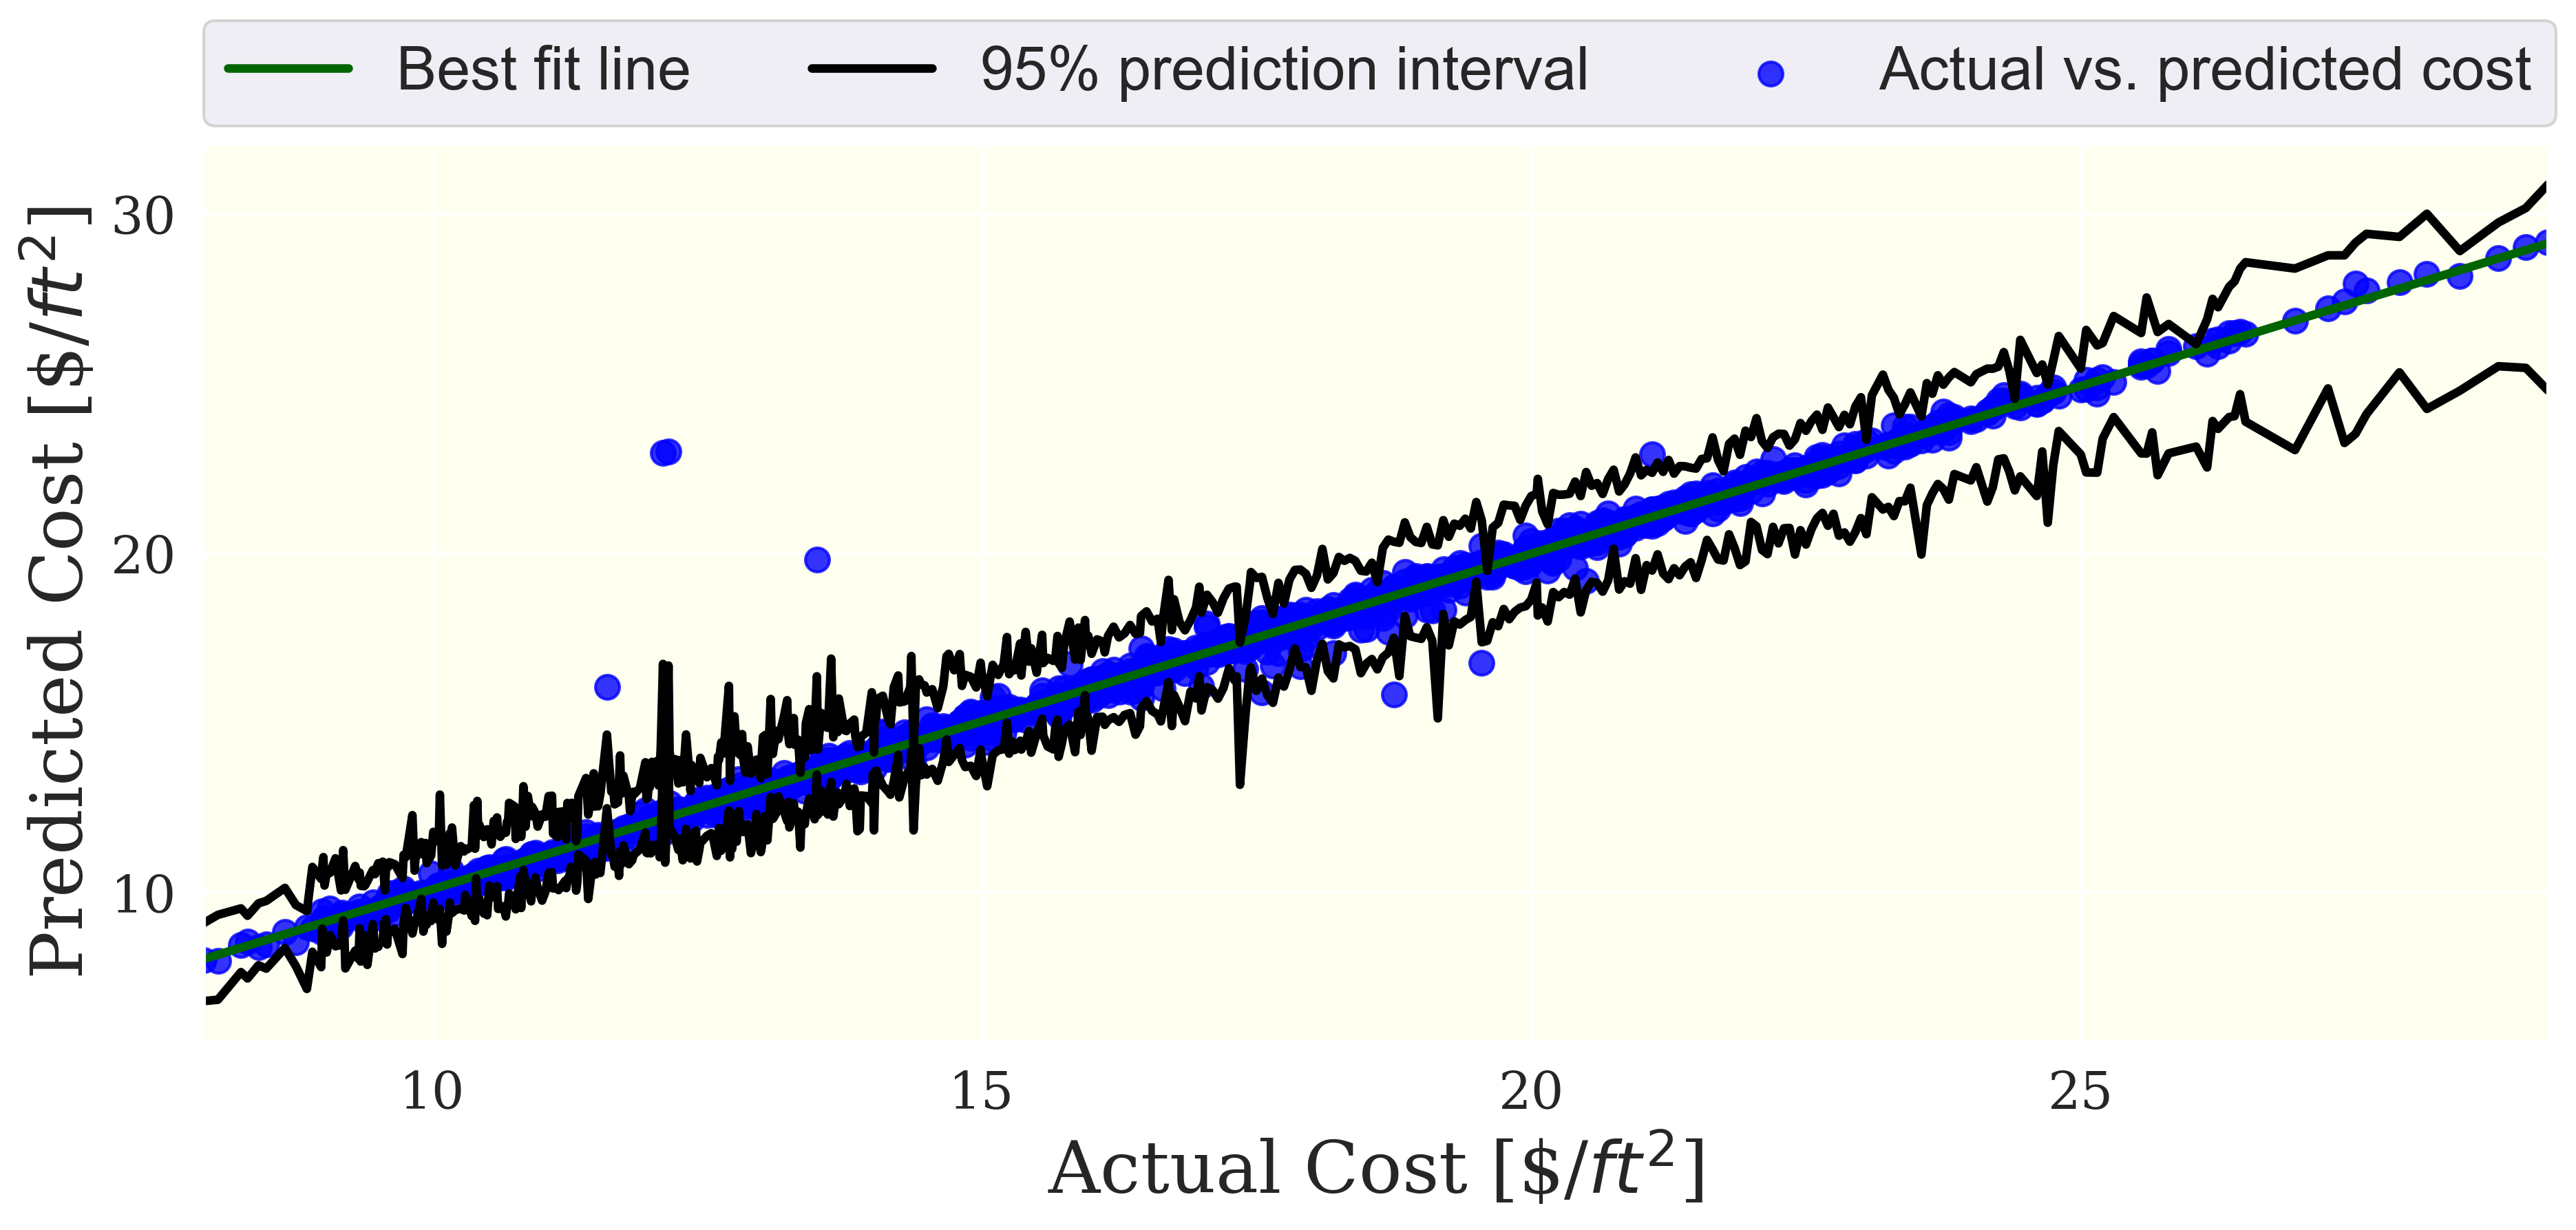

In [17]:
fig = plt.figure(figsize=(14,7),dpi=300)
ax = fig.add_subplot(1,1,1,facecolor='ivory')
sns.regplot(y_test, lgb.predict(X_test), x_ci='ci', label = 'Actual vs. predicted cost',
            scatter_kws={'color': 'blue', 's': 70},
            line_kws={'color': 'darkgreen', 'linewidth': 3, 'label': 'Best fit line'})

sns.lineplot(y_test, ngb_default.pred_dist(X_test).loc - 1.96 * ngb_default.pred_dist(X_test).scale, color = "black", 
             linestyle = "--", linewidth=3, ci =None)
sns.lineplot(y_test, ngb_default.pred_dist(X_test).loc + 1.96 * ngb_default.pred_dist(X_test).scale, color = "black", 
             linestyle = "--", linewidth=3, ci =None, label = '95% prediction interval')
plt.xlabel("Actual Cost [\$/$ft^2$]", fontsize=25, fontname='Serif')
plt.ylabel("Predicted Cost [\$/$ft^2$]", fontsize=25, fontname='Serif')
plt.xticks(fontsize=18, fontname='Serif')
plt.yticks(fontsize=18, fontname='Serif')
plt.figaspect(1.)
plt.legend(bbox_to_anchor=(0,1.02), loc="lower left", ncol=3, borderaxespad=0., prop={'size': 21})
plt.tight_layout(pad=1.08)
plt.savefig('Final Scatter Plot.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


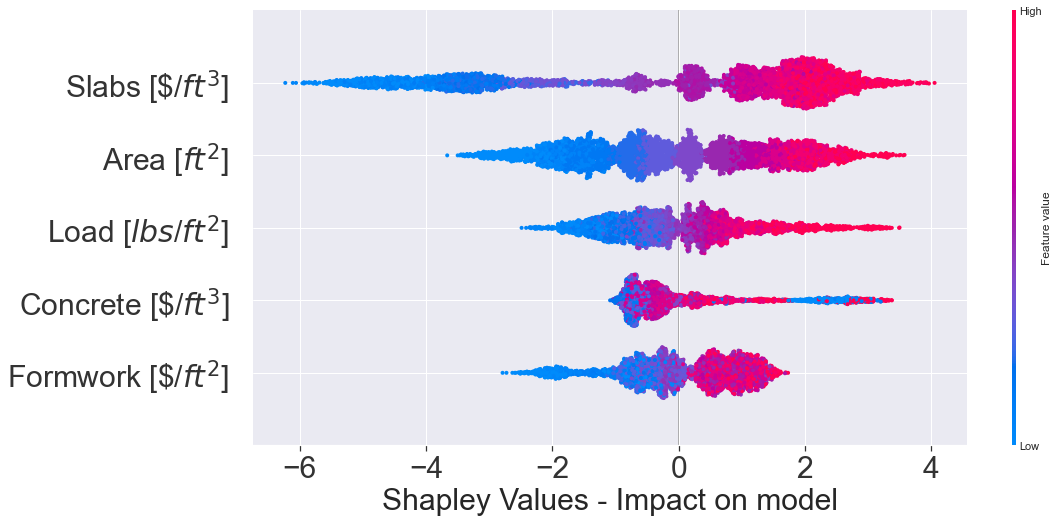

In [18]:
lgb_shap = LGBMRegressor(n_estimators=lgb.best_params_.get('n_estimators'),max_depth=lgb.best_params_.get('max_depth'),
                         learning_rate=lgb.best_params_.get('learning_rate'))

lgb_shap.fit(X, y.ravel())

explainer = shap.TreeExplainer(lgb_shap)
shap_values = explainer.shap_values(Data_DF[Feature_Names].to_numpy())

shap.summary_plot(shap_values, Data_DF[Feature_Names].to_numpy(), Feature_Names, plot_size=(16,8), show=False)
plt.xlabel('Shapley Values - Impact on model', fontsize=30)
plt.tick_params(labelsize=30)
plt.savefig('Feature Importance - SHAP.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

In [19]:
shap.force_plot(explainer.expected_value, shap_values, Data_DF[Feature_Names].to_numpy())

shap.force_plot is slow for many thousands of rows, try subsampling your data.


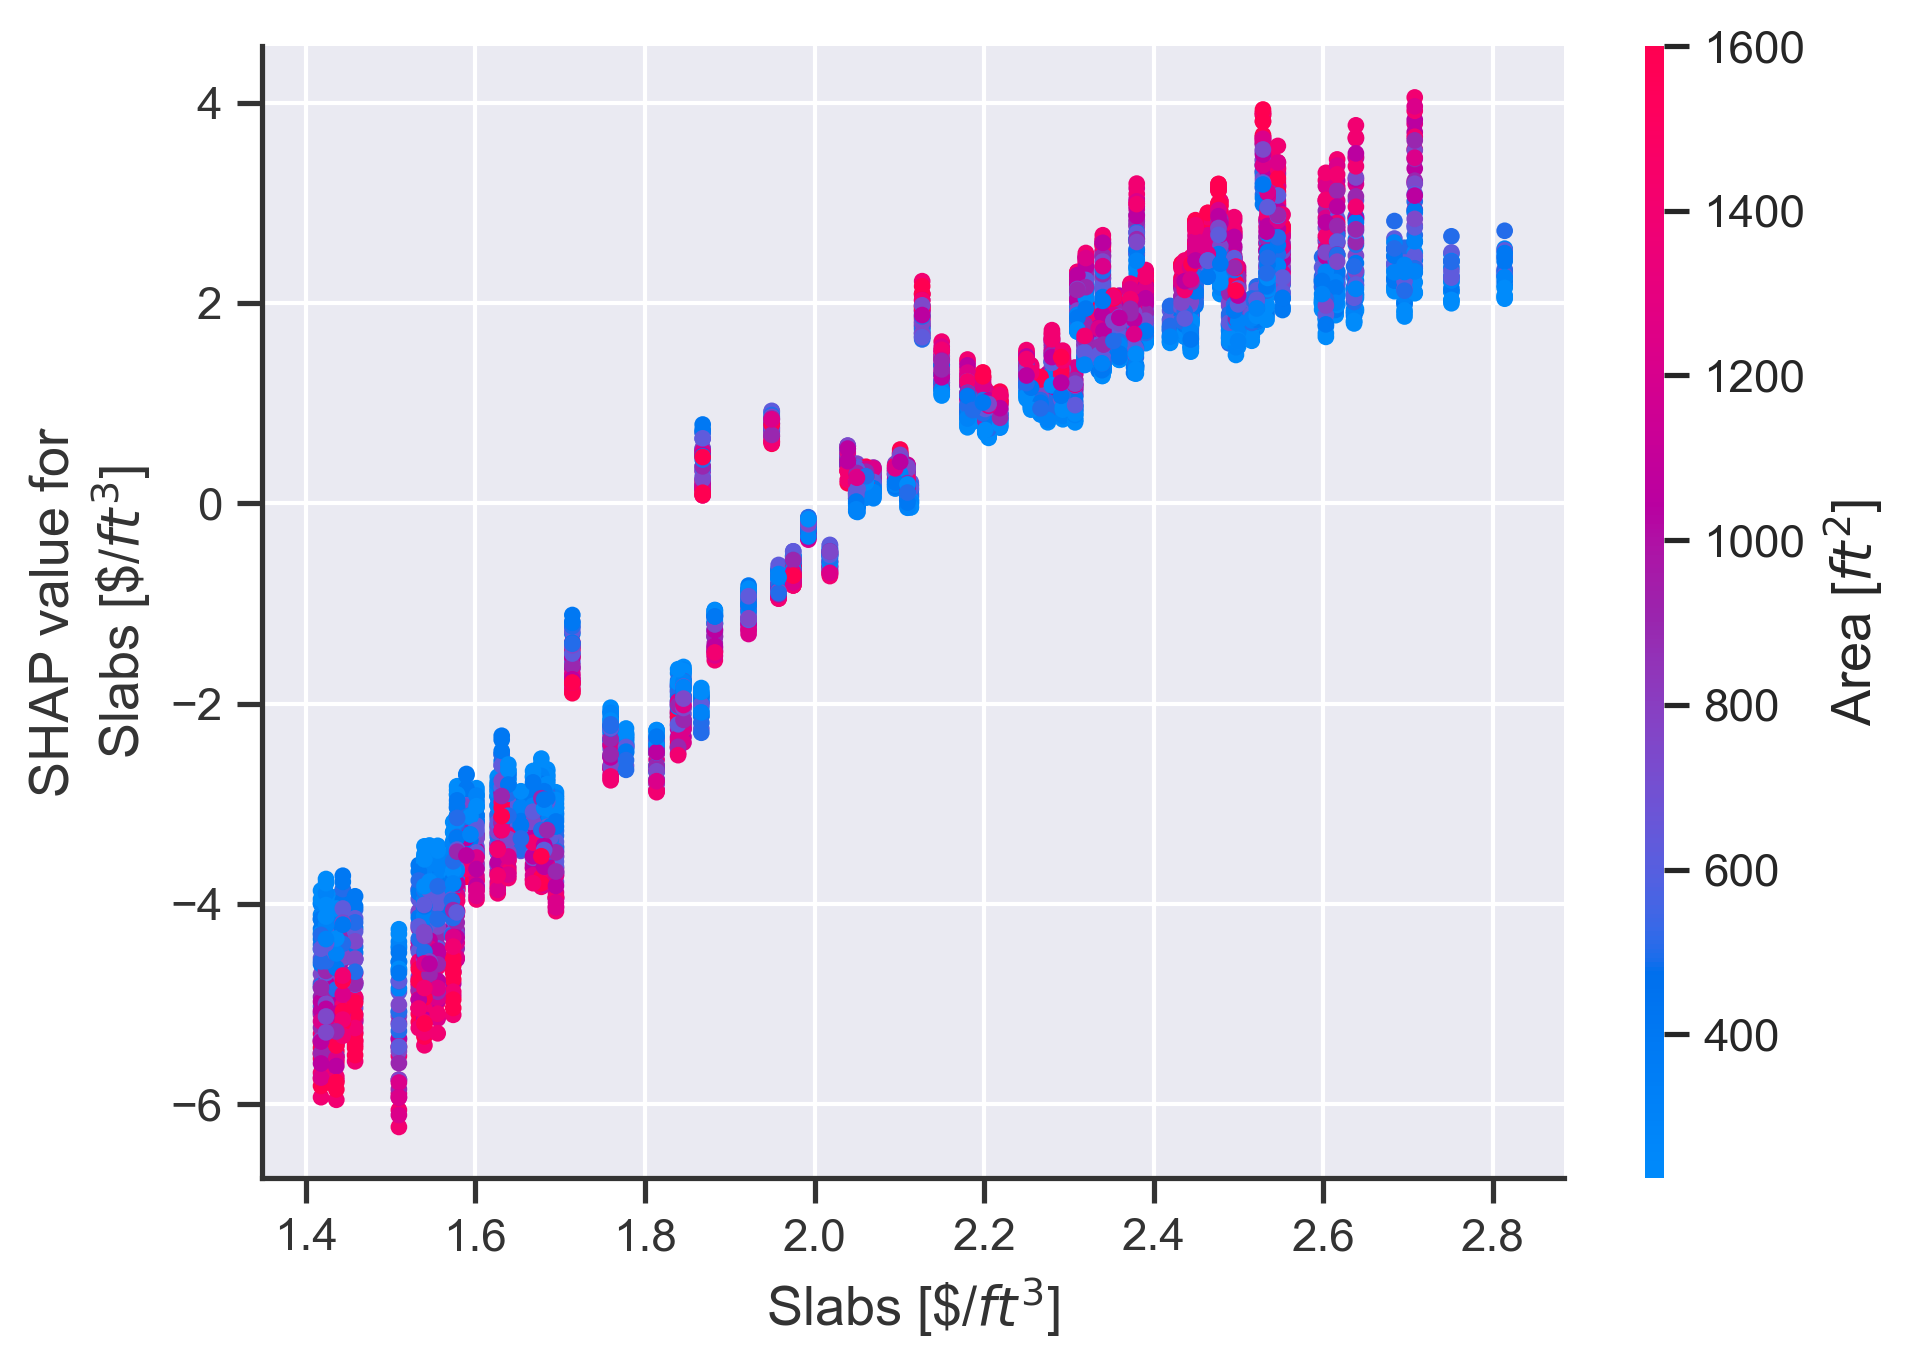

In [20]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Slabs [\$/$ft^3$]',shap_values, Data_DF[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Slabs.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

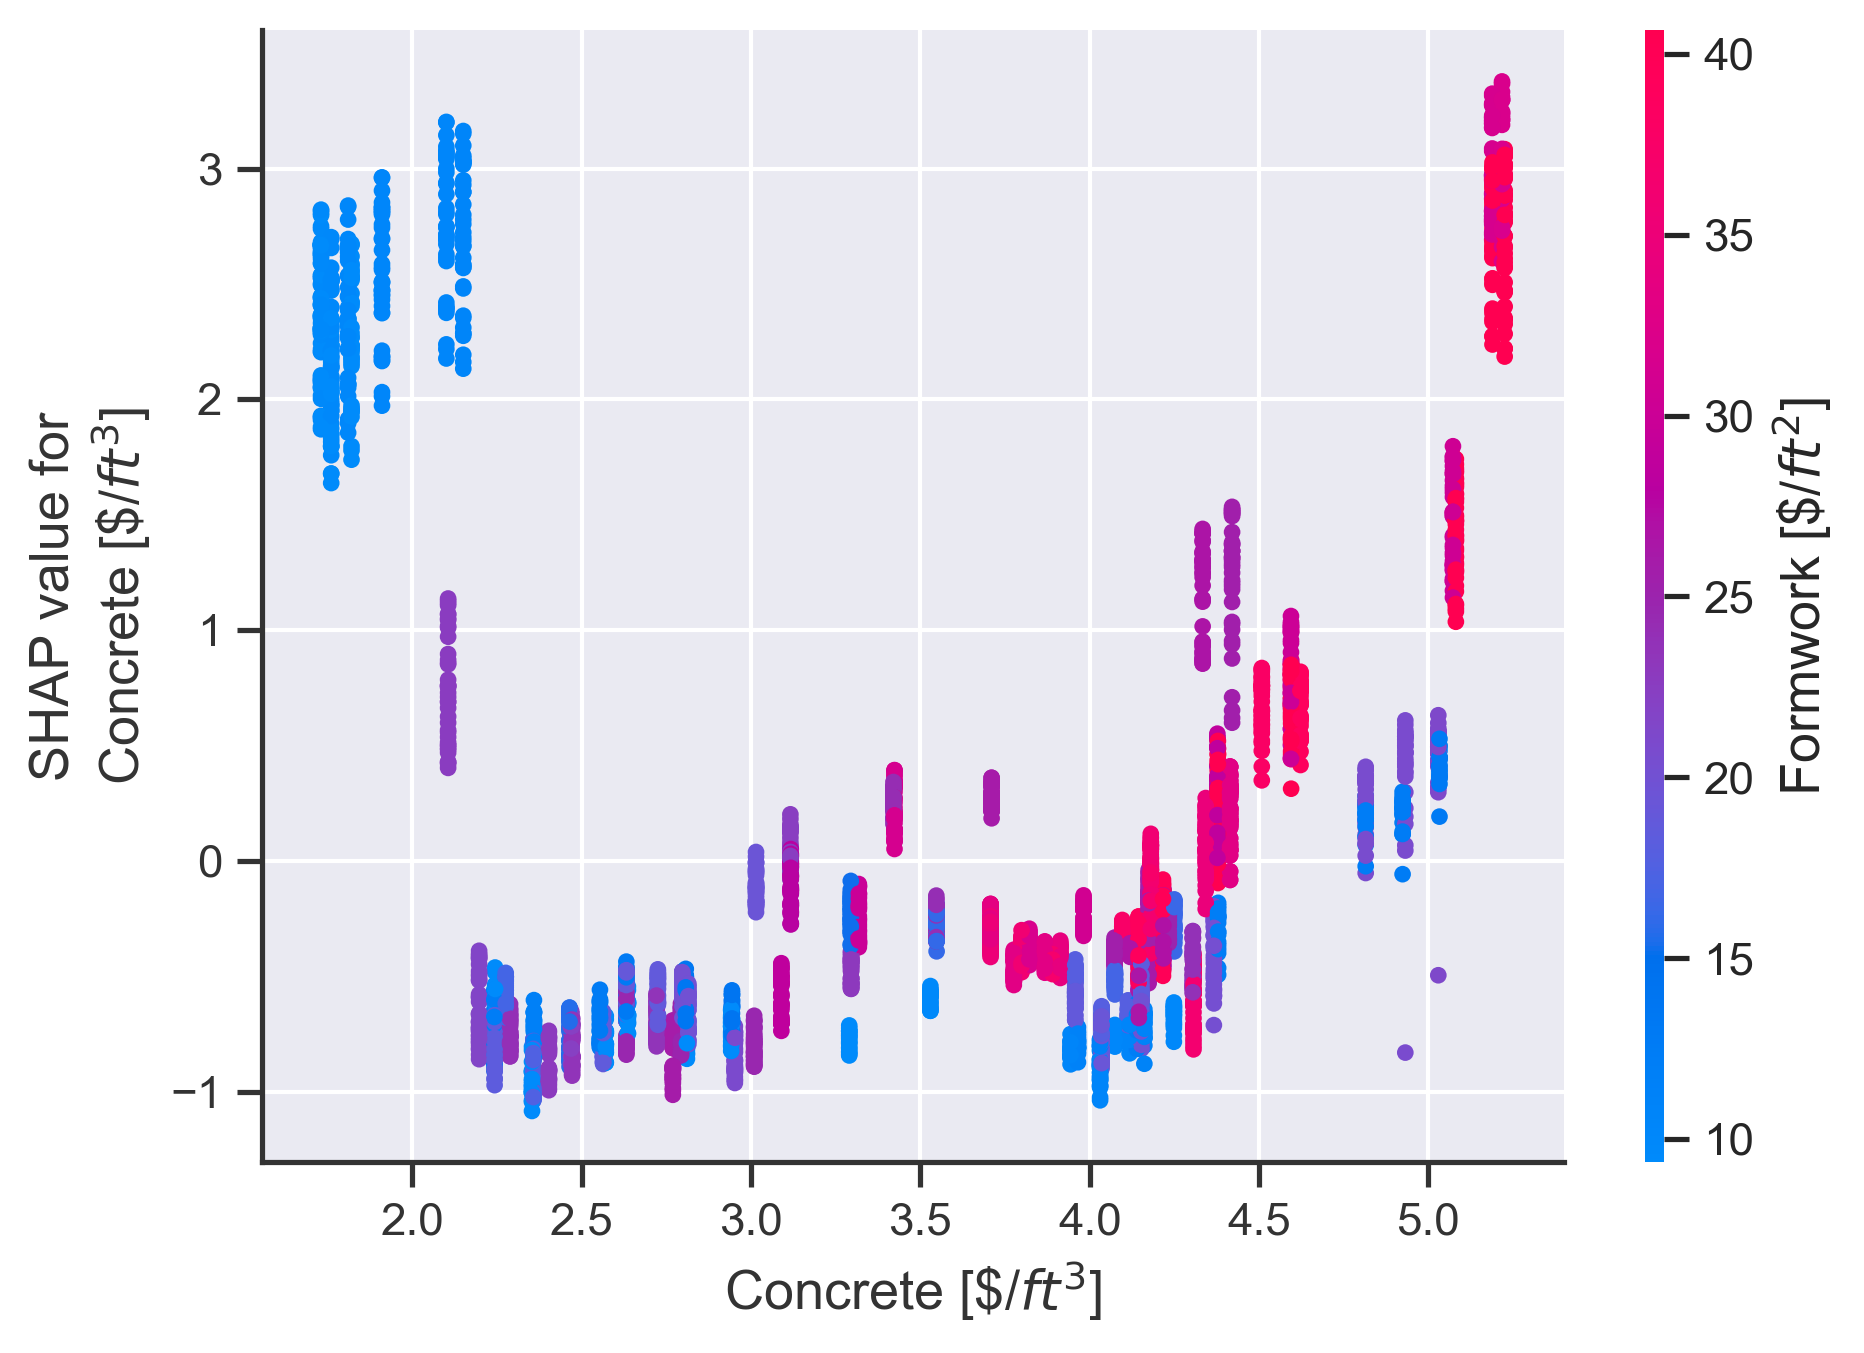

In [21]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Concrete [\$/$ft^3$]',shap_values, Data_DF[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Concrete.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

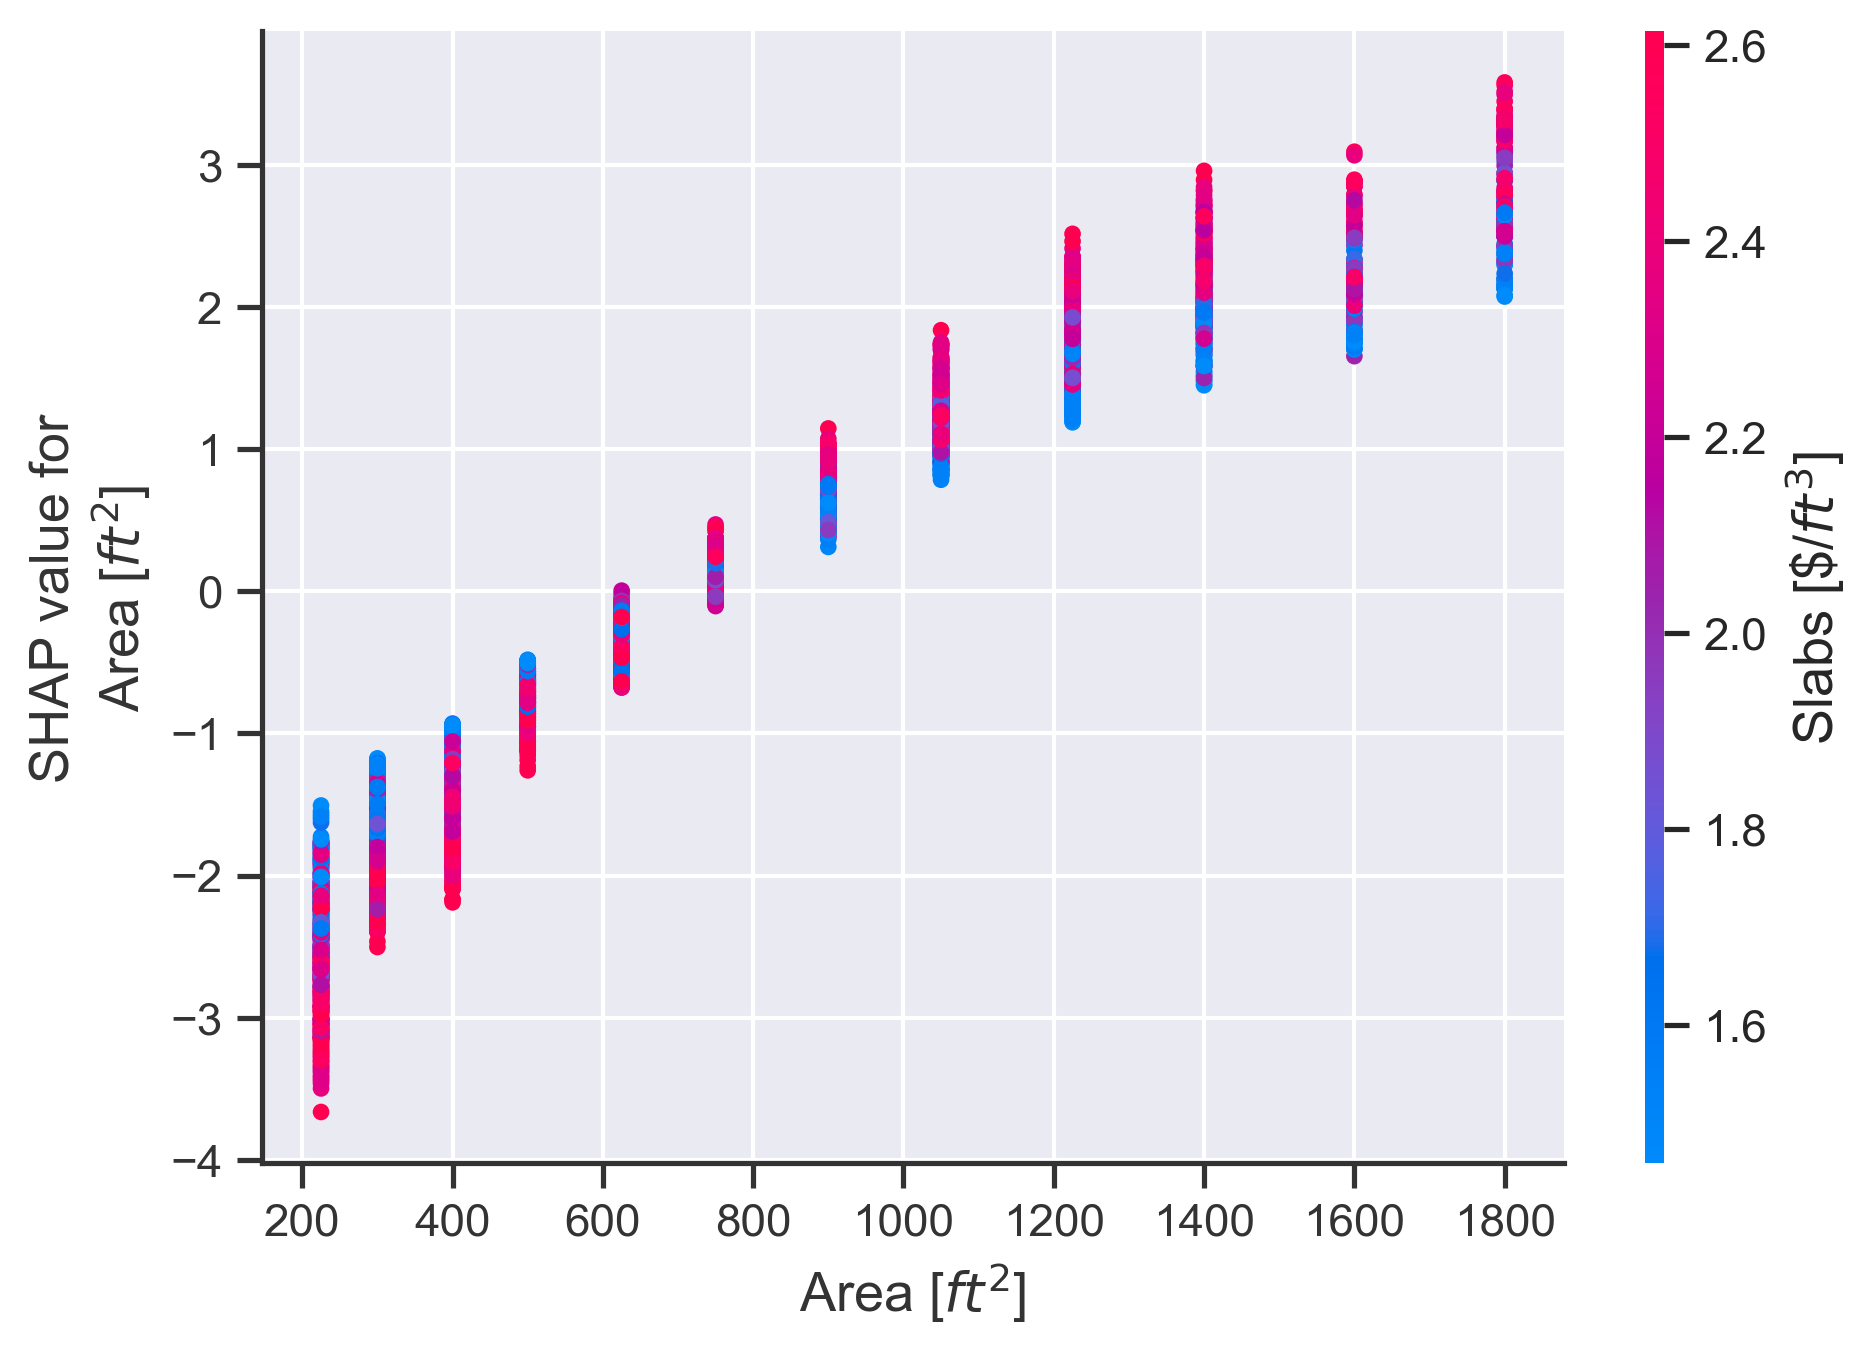

In [22]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Area [$ft^2$]',shap_values, Data_DF[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Area.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

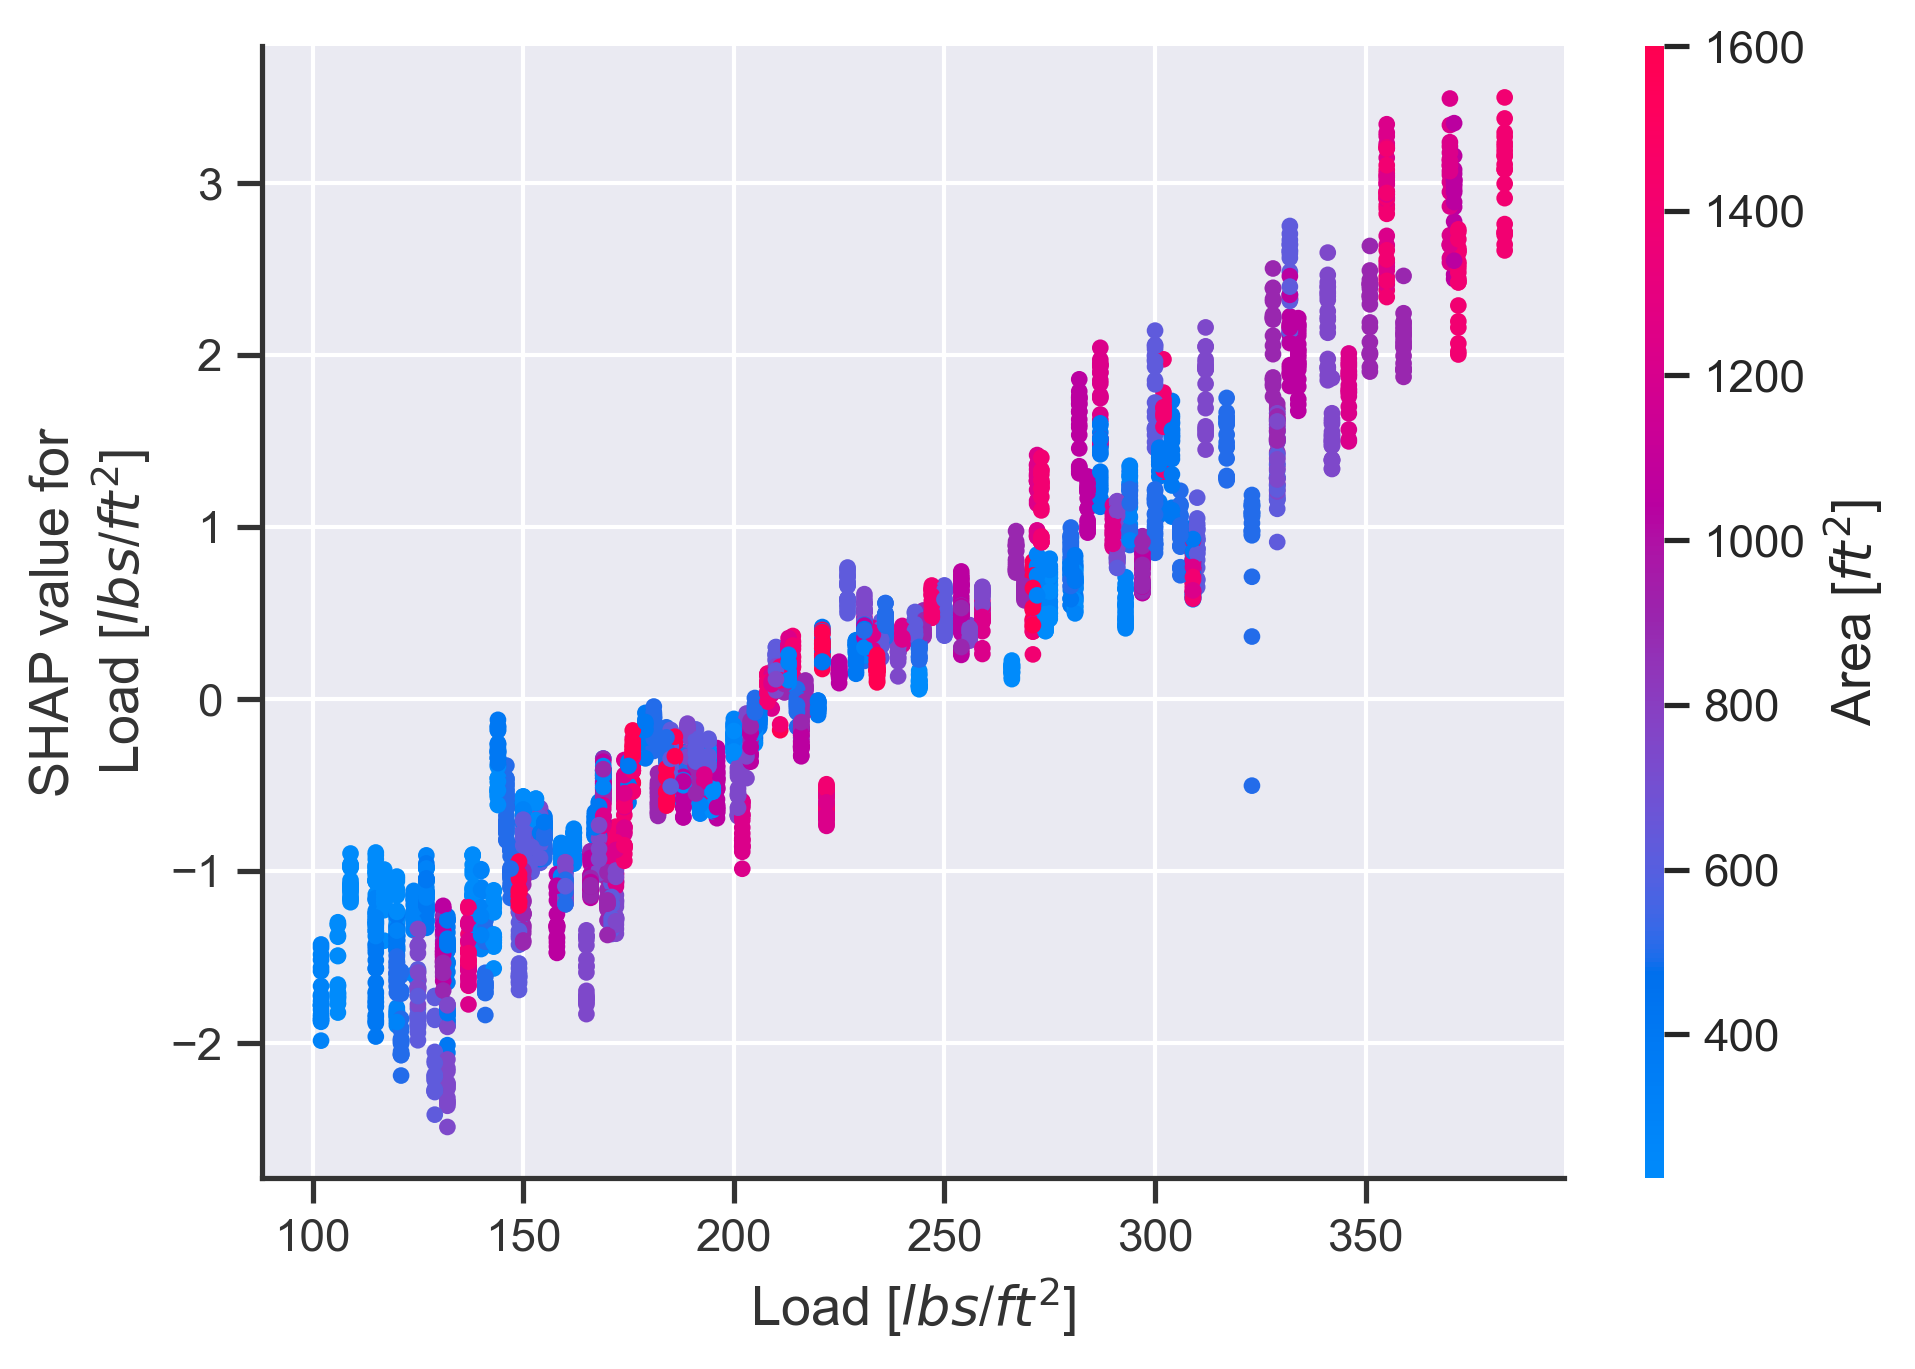

In [23]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Load [$lbs$/$ft^2$]',shap_values, Data_DF[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Load.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

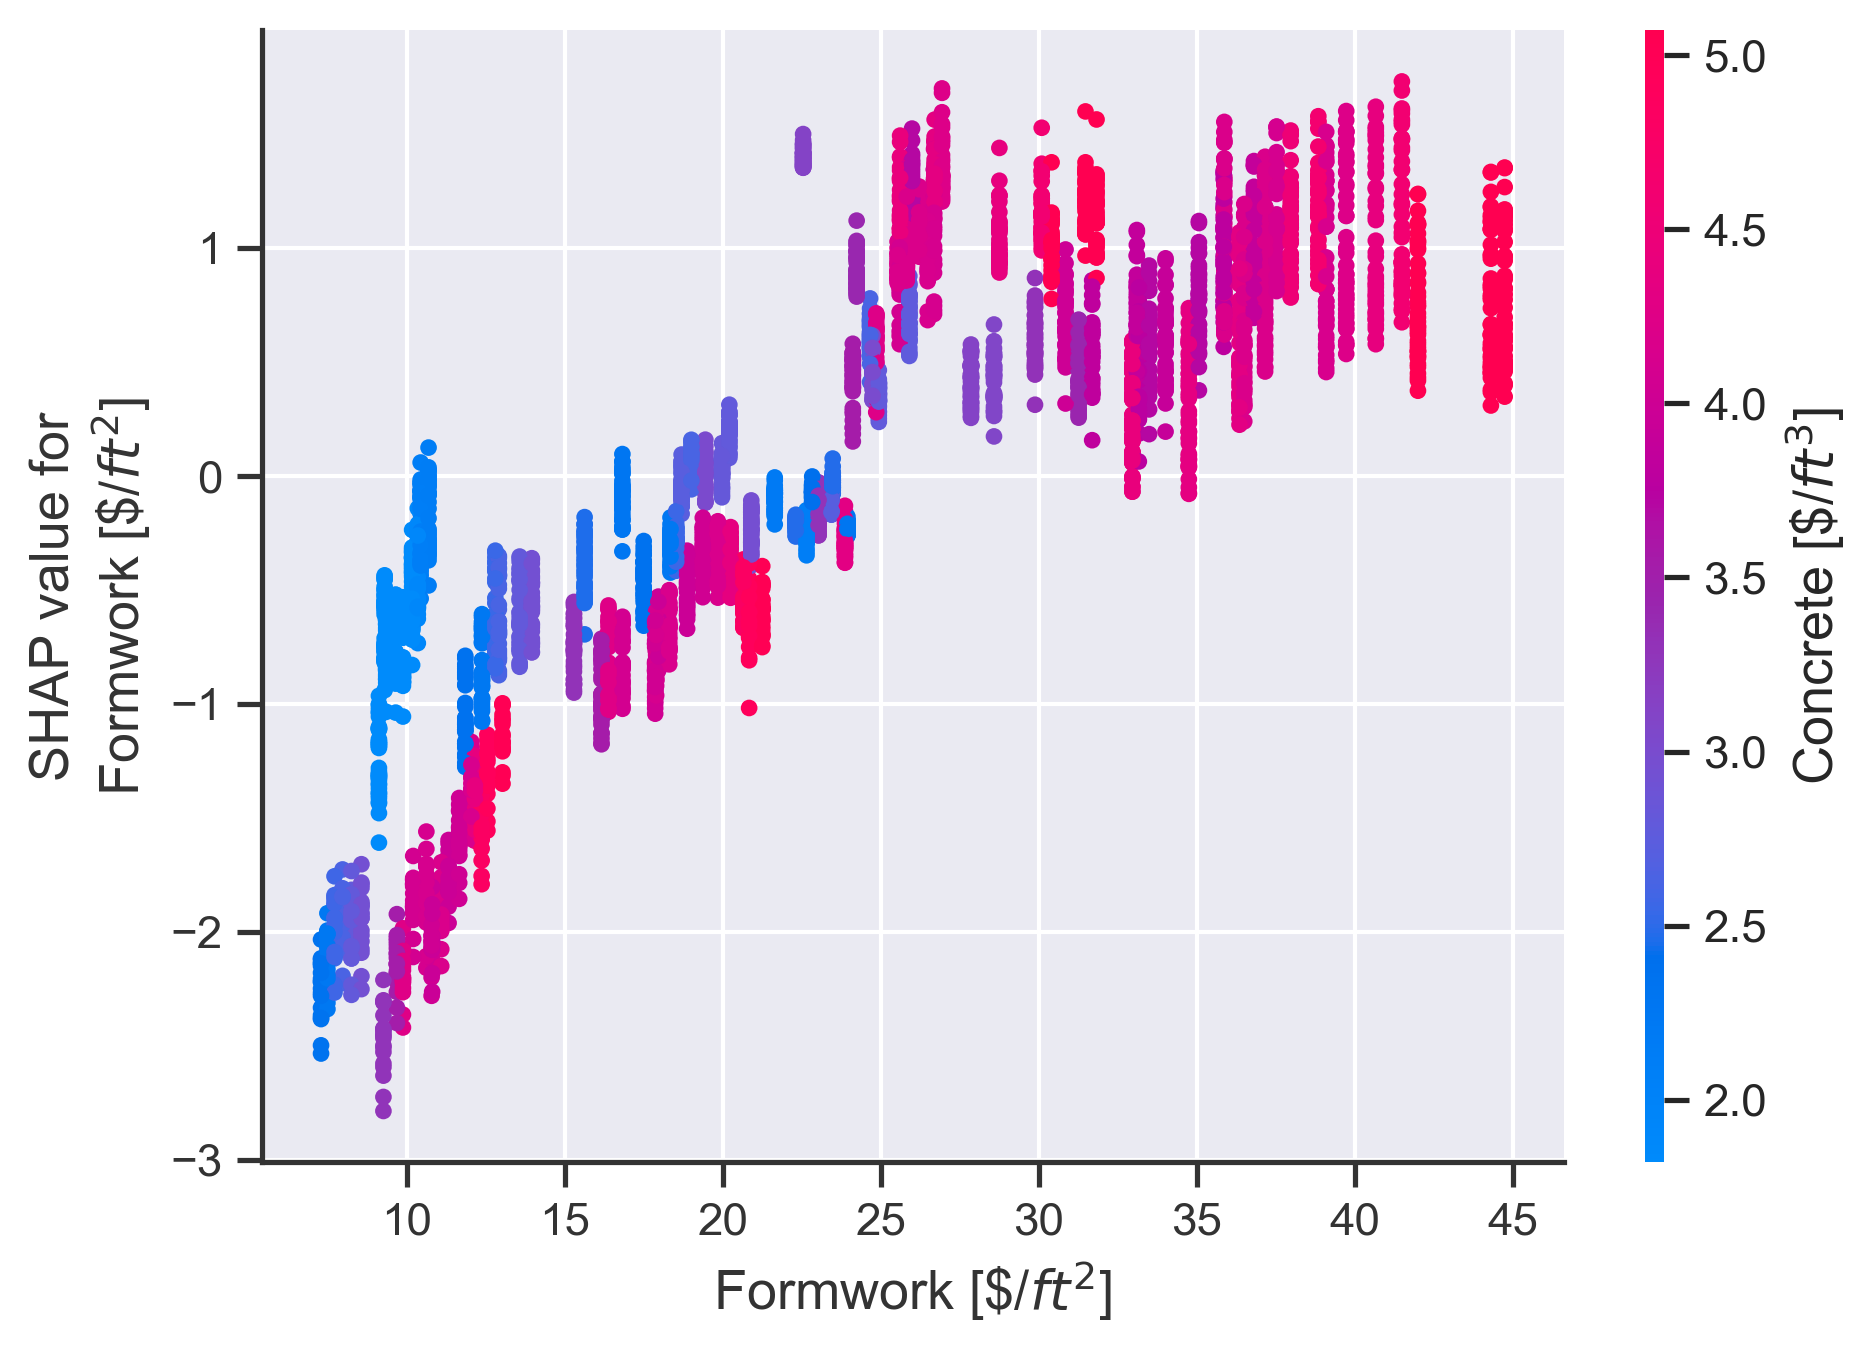

In [24]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Formwork [\$/$ft^2$]',shap_values, Data_DF[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Formwork.pdf', format='pdf', dpi=300, bbox_inches = 'tight')